In [1]:
import ee
import pandas as pd
import numpy as np
from dfply import *

import plotnine
from plotnine import *

import sys
from tqdm.auto import tqdm

In [2]:
# authenticate earthengine api
ee.Initialize()

In [3]:
# import custom moduls
sys.path.append('./')

from Modules.Modules import filter_exclude, get_img_df, zonal_sum_GAEZ_production
from Modules.Parallize_df import parallelize_dataframe

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [4]:
# import GAEZ data from ee_asset
GAEZ_list = ! earthengine ls users/wangjinzhulala/Paper_3/03_GAEZ

# region-scale for downloading
NCP_shp_mask = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")
GAEZ_pix_scale = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Modified_Fournier_Index_2011_2040_RCP60").projection().nominalScale().getInfo()

# import the admin boundary
China_cities = ee.FeatureCollection("users/wangjinzhulala/China_Boundary/1_China_Cities_cn")
NCP_cites = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_city_boundary")
NCP_provinces = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

### reading data

In [5]:
# 1-1) 2020 cropland area (k ha)
GAEZ_cropland_2020_corrected = pd.read_pickle('./result_csv/GAEZ_cropland_2020_corrected.pkl')

# 1-2) cropland area after urban encroachment
urban_encroach_img = pd.read_pickle('./result_csv/urban_encroach_img.pkl') >> rename(SSP='Scenario') >> mask(X.year >=2020)

# 1-3) the cropland area increase imgs
reclamation_each_pix_mosaic = pd.read_pickle('./result_csv/reclamation_each_pix_mosaic.pkl')

# 1-4) final future cropland area (k ha)
future_harvested_area   = pd.read_pickle(f'./result_csv/future_harvested_area.pkl') >> rename(SSP='Scenario')
future_harvested_area_df = pd.read_csv(f'./result_csv/future_harvested_area_df.csv')


# 2) yearbook crop yield records (t/ha)
crop_yield_history_1990_2020 = pd.read_csv('./result_csv/crop_yield_history_1975_2020.csv') >> mask(X.year>=1990)
# crop_yield_history_1990_2020_sutract_increase = pd.read_csv('./result_csv/crop_yield_history_1975_2020_sutract_increase.csv')\
#                          >> mask(X.year>=1990)

# 3-1) the GYGA attainable yield (t/ha) weighted by GAEZ rainfed/irrigated area
GYGA_weighted_by_area_ratio = pd.read_csv('./result_csv/GYGA_weighted_by_area_ratio.csv')

# 3-2) the GAEZ attainable yield (t/ha) forced to agree with GYGA
GAEZ_attainable_t_ha_forced_with_GYGA = pd.read_pickle('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA.pkl') 
GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul = pd.read_csv('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul.csv')\
                                >> mask(X.year>=1990)
GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul['rcp'] = GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul['rcp'].astype('category')

# 3-3) the GAEZ_2020 actual yield (t/ha) imgs forced to agree with yearbook crop yield in 2020
GAEZ_actual_forced_with_Yearbook = pd.read_pickle('./result_csv/GAEZ_actual_forced_with_Yearbook.pkl')
GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot = pd.read_csv('./result_csv/GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot.csv')
GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot['rcp'] = GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot['rcp'].astype('category')

# 3-4) the GAEZ_2010 actual yield (t/ha) imgs being projected to 2100 using the 3-3) as multiplier
GAEZ_actual_yield_propogated = pd.read_pickle('./result_csv/GAEZ_actual_yield_propogated.pkl')
GAEZ_actual_yield_propogated_area_weighted_mean_df = pd.read_csv('./result_csv/GAEZ_actual_yield_propogated_area_weighted_mean_df.csv')
GAEZ_actual_yield_propogated_area_weighted_mean_df['rcp'] = GAEZ_actual_yield_propogated_area_weighted_mean_df['rcp'].astype('category')

# 3-5) the 3-4) data (t/ha) being supplied with the trend in the yearbook recoreds and projected to 2100
GAEZ_actual_link_Yearbook_trend = pd.read_pickle('./result_csv/GAEZ_actual_link_Yearbook_trend.pkl')
GAEZ_actual_link_Yearbook_trend_area_weighted_mean_df = pd.read_csv('./result_csv/GAEZ_actual_link_Yearbook_trend_area_weighted_mean_df.csv')
GAEZ_actual_link_Yearbook_trend_area_weighted_mean_df['rcp'] = GAEZ_actual_link_Yearbook_trend_area_weighted_mean_df['rcp'].astype('category')


# 4) the crop yiled (t/ha) of scenario-1-BAU (Business As Usuall): 
#   where the crop yield increses as the trend in yearbook and stops when hitting the attainable yield
Scenario_BAU_yield_img = pd.read_pickle('./result_csv/Scenario_BAU_yield_img.pkl') >> drop(['image_add','image_mul'])
Scenario_BAU_yield_img['Scenario'] = 'BAU'
Scenario_BAU_yield_img_area_weighted_mean_df = pd.read_csv('./result_csv/Scenario_BAU_yield_img_area_weighted_mean_df.csv')
Scenario_BAU_yield_img_area_weighted_mean_df['rcp'] = Scenario_BAU_yield_img_area_weighted_mean_df['rcp'].astype('str')
Scenario_BAU_yield_img_area_weighted_mean_df['Scenario'] = 'BAU'

# # 5) crop yiled (t/ha) of the scenario-2-plateaued: 
# #   the crop yield increses at the rate where the yearbook trend linearly decreses to 0 during 2010-2050
# Scanario_plateaued = pd.read_pickle('./result_csv/Scanario_plateaued.pkl')
# Scanario_plateaued['Scenario'] = 'Plateaued'
# Scenario_plateaued_weighted_mean_df = pd.read_csv('./result_csv/Scanario_plateaued_weighted_mean_df.csv')
# Scenario_plateaued_weighted_mean_df['rcp'] = Scenario_plateaued_weighted_mean_df['rcp'].astype('str')
# Scenario_plateaued_weighted_mean_df['Scenario'] = 'Plateaued'

# # 6) merge two scenarios into one df
# Secnario_imgs = pd.concat([Scenario_BAU_yield_img,Scanario_plateaued])
# Scenario_df = pd.concat([Scenario_BAU_yield_img_area_weighted_mean_df,Scenario_plateaued_weighted_mean_df])

In [6]:
# dict to corresponding file_names to crops
crop_dict = {'maize':'Maize','wheat':'Wheat','rice':'Wetland_rice'}
yearbook_path = '../../Data/06_Yearbook/Agricultural_production/Provincial_historical_yield'

# pair Chinese city names with english spelling
city_cn_en = dict(zip(['北京市','天津市', '河北省','江苏省', '安徽省', '河南省', '山东省'],
             ['Beijing','Tianjin', 'Hebei','Jiangsu', 'Anhui', 'Henan', 'Shandong']))

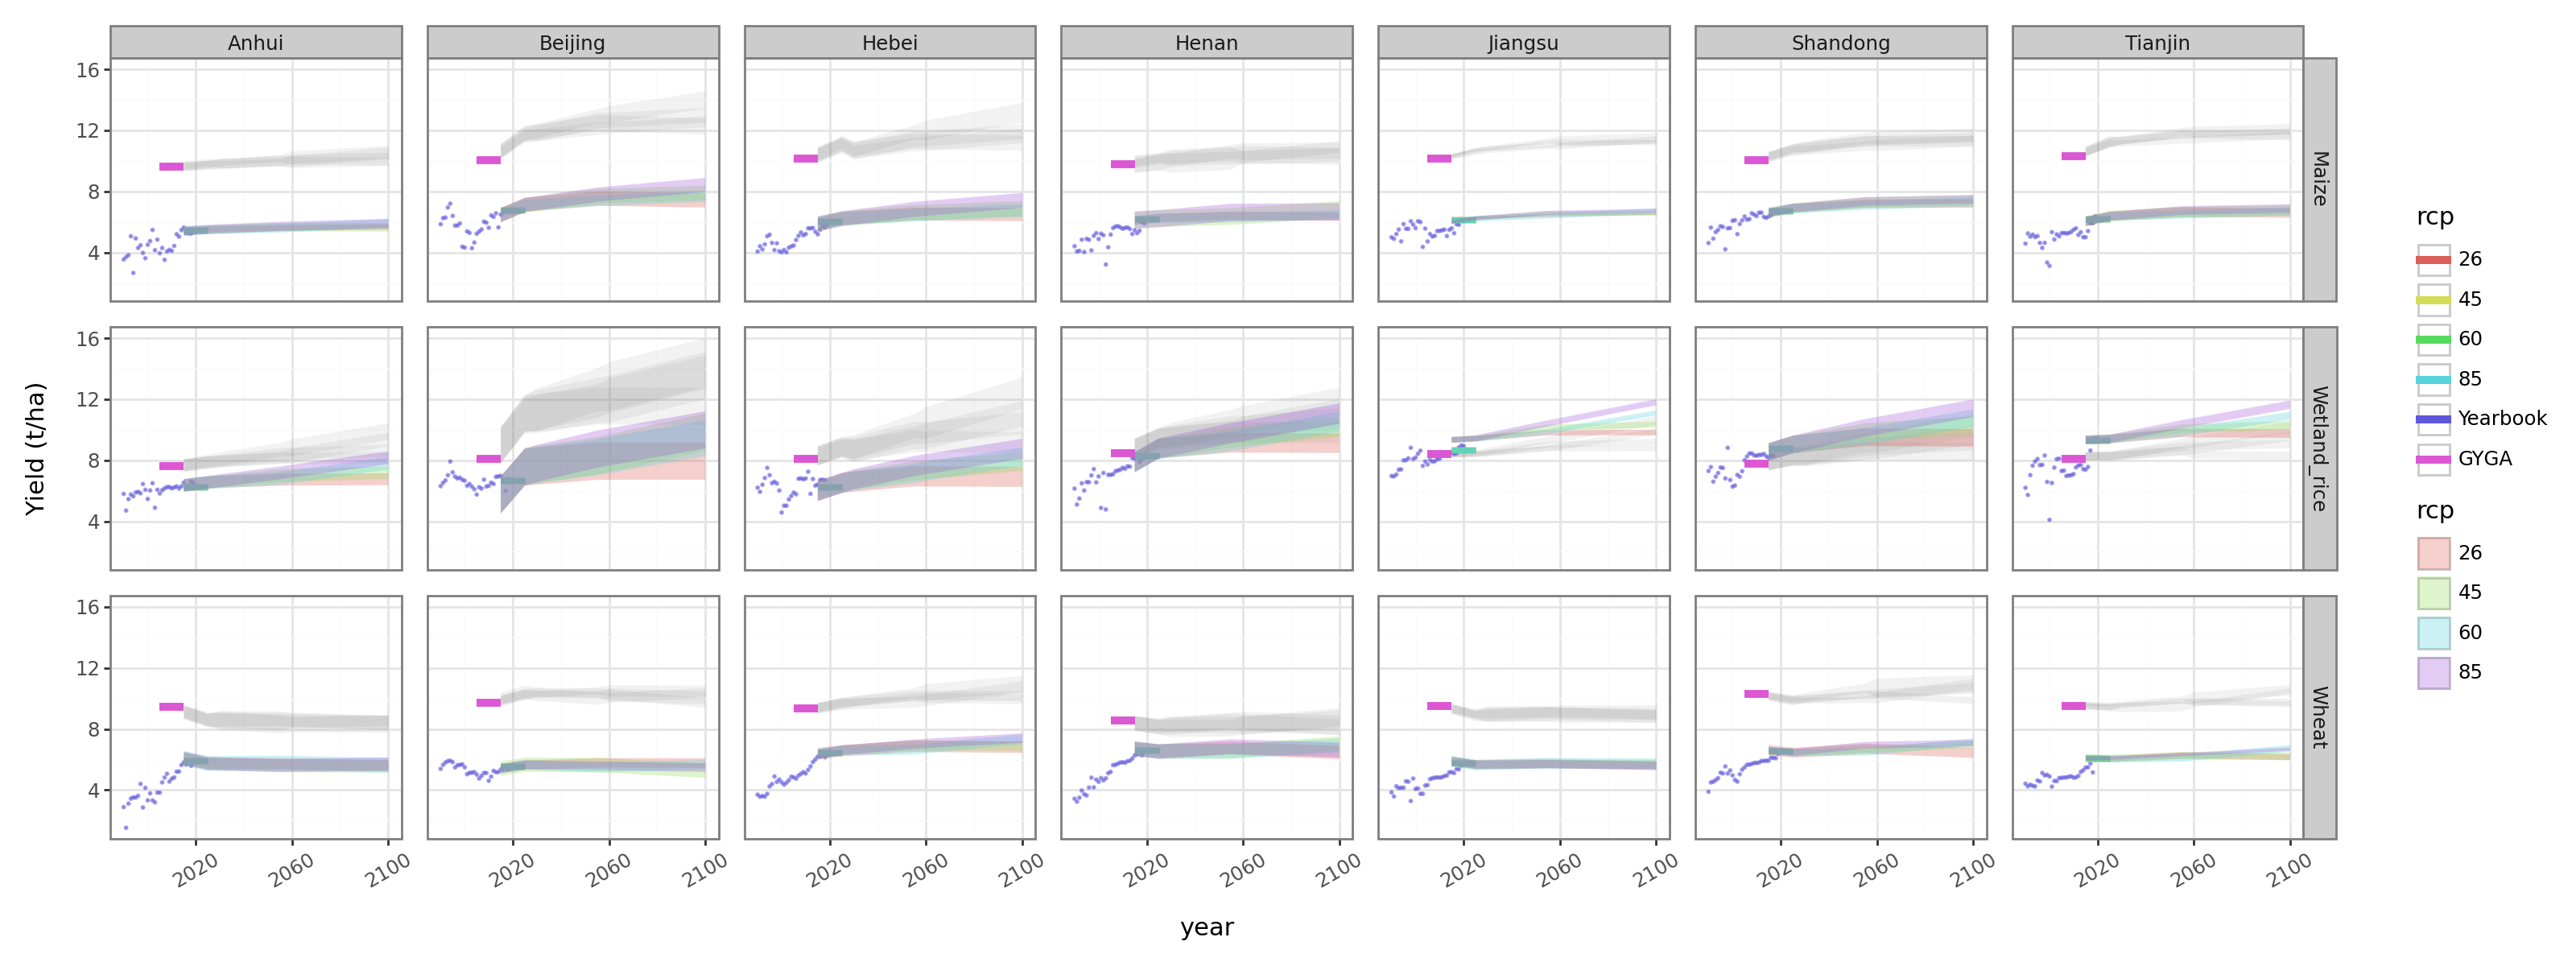

In [7]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 # attainable yield
 geom_ribbon(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, 
       aes(x='year',ymax='top',ymin='bot',group='rcp'),alpha=0.1,fill='grey') +
 # yearbook records
 geom_point(crop_yield_history_1990_2020, 
       aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
 # GYGA attainbale yield in 2010
 geom_line(GYGA_weighted_by_area_ratio, 
           aes('year','Mean Production',color='rcp'),size=2) +
 # GAEZ actual yield in 2020
 geom_line(GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot, 
      aes('year','Mean Production',color='rcp'),size=1.5,alpha=0.7) +
 # crop yield increase with the trend in yearbook records 
 geom_ribbon(GAEZ_actual_yield_propogated_area_weighted_mean_df, 
      aes(x='year',ymax='top',ymin='bot',fill='rcp',group='rcp'),alpha=0.3) +
 facet_grid('crop~Province') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 scale_x_continuous(breaks=range(1980,2101,40)) +
 ylab('Yield (t/ha)')
)

#### Plot the projected crop yield: 
- historical crop yield (t/ha) 
- the projected crop yield (t/ha)
- the attianbale crop yield (t/ha)

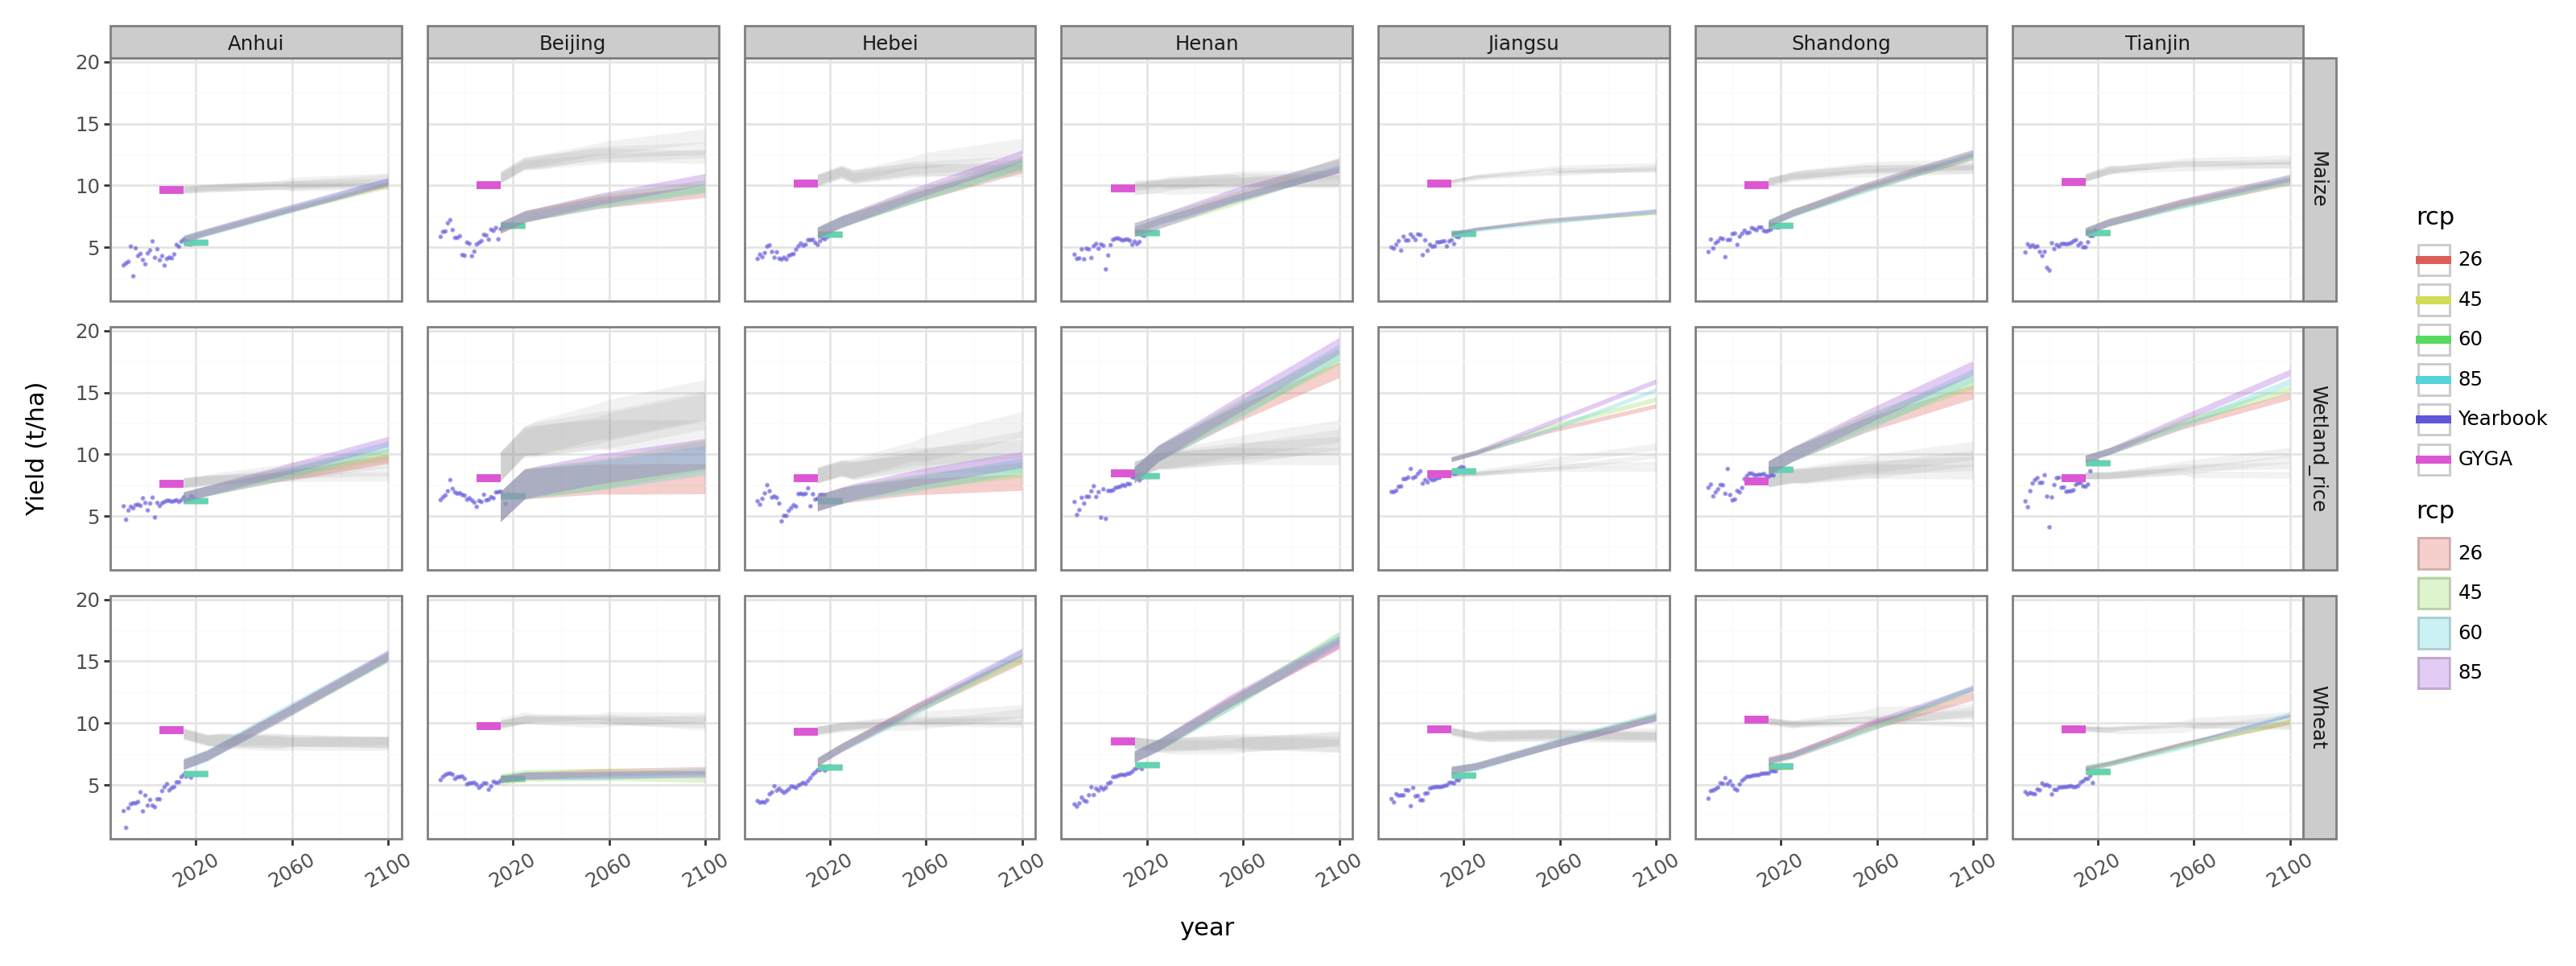

In [8]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 # attainable yield
 geom_ribbon(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes(x='year',ymax='top',ymin='bot',group='rcp'),alpha=0.1,fill='grey') +
 # yearbook records
 geom_point(crop_yield_history_1990_2020, aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
 # GYGA attainbale yield in 2010
 geom_line(GYGA_weighted_by_area_ratio, aes('year','Mean Production',color='rcp'),size=2) +
 # GAEZ actual yield in 2010
 geom_line(GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot, aes('year','Mean Production',color='rcp'),size=1.5,alpha=0.7) +
 # crop yield increase with the trend in yearbook records 
 geom_ribbon(GAEZ_actual_link_Yearbook_trend_area_weighted_mean_df, aes(x='year',ymax='top',ymin='bot',fill='rcp',group='rcp'),alpha=0.3) +
 facet_grid('crop~Province') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 scale_x_continuous(breaks=range(1980,2101,40)) +
 ylab('Yield (t/ha)')
)

#### Plot the business as usuall (BAU) crop yield

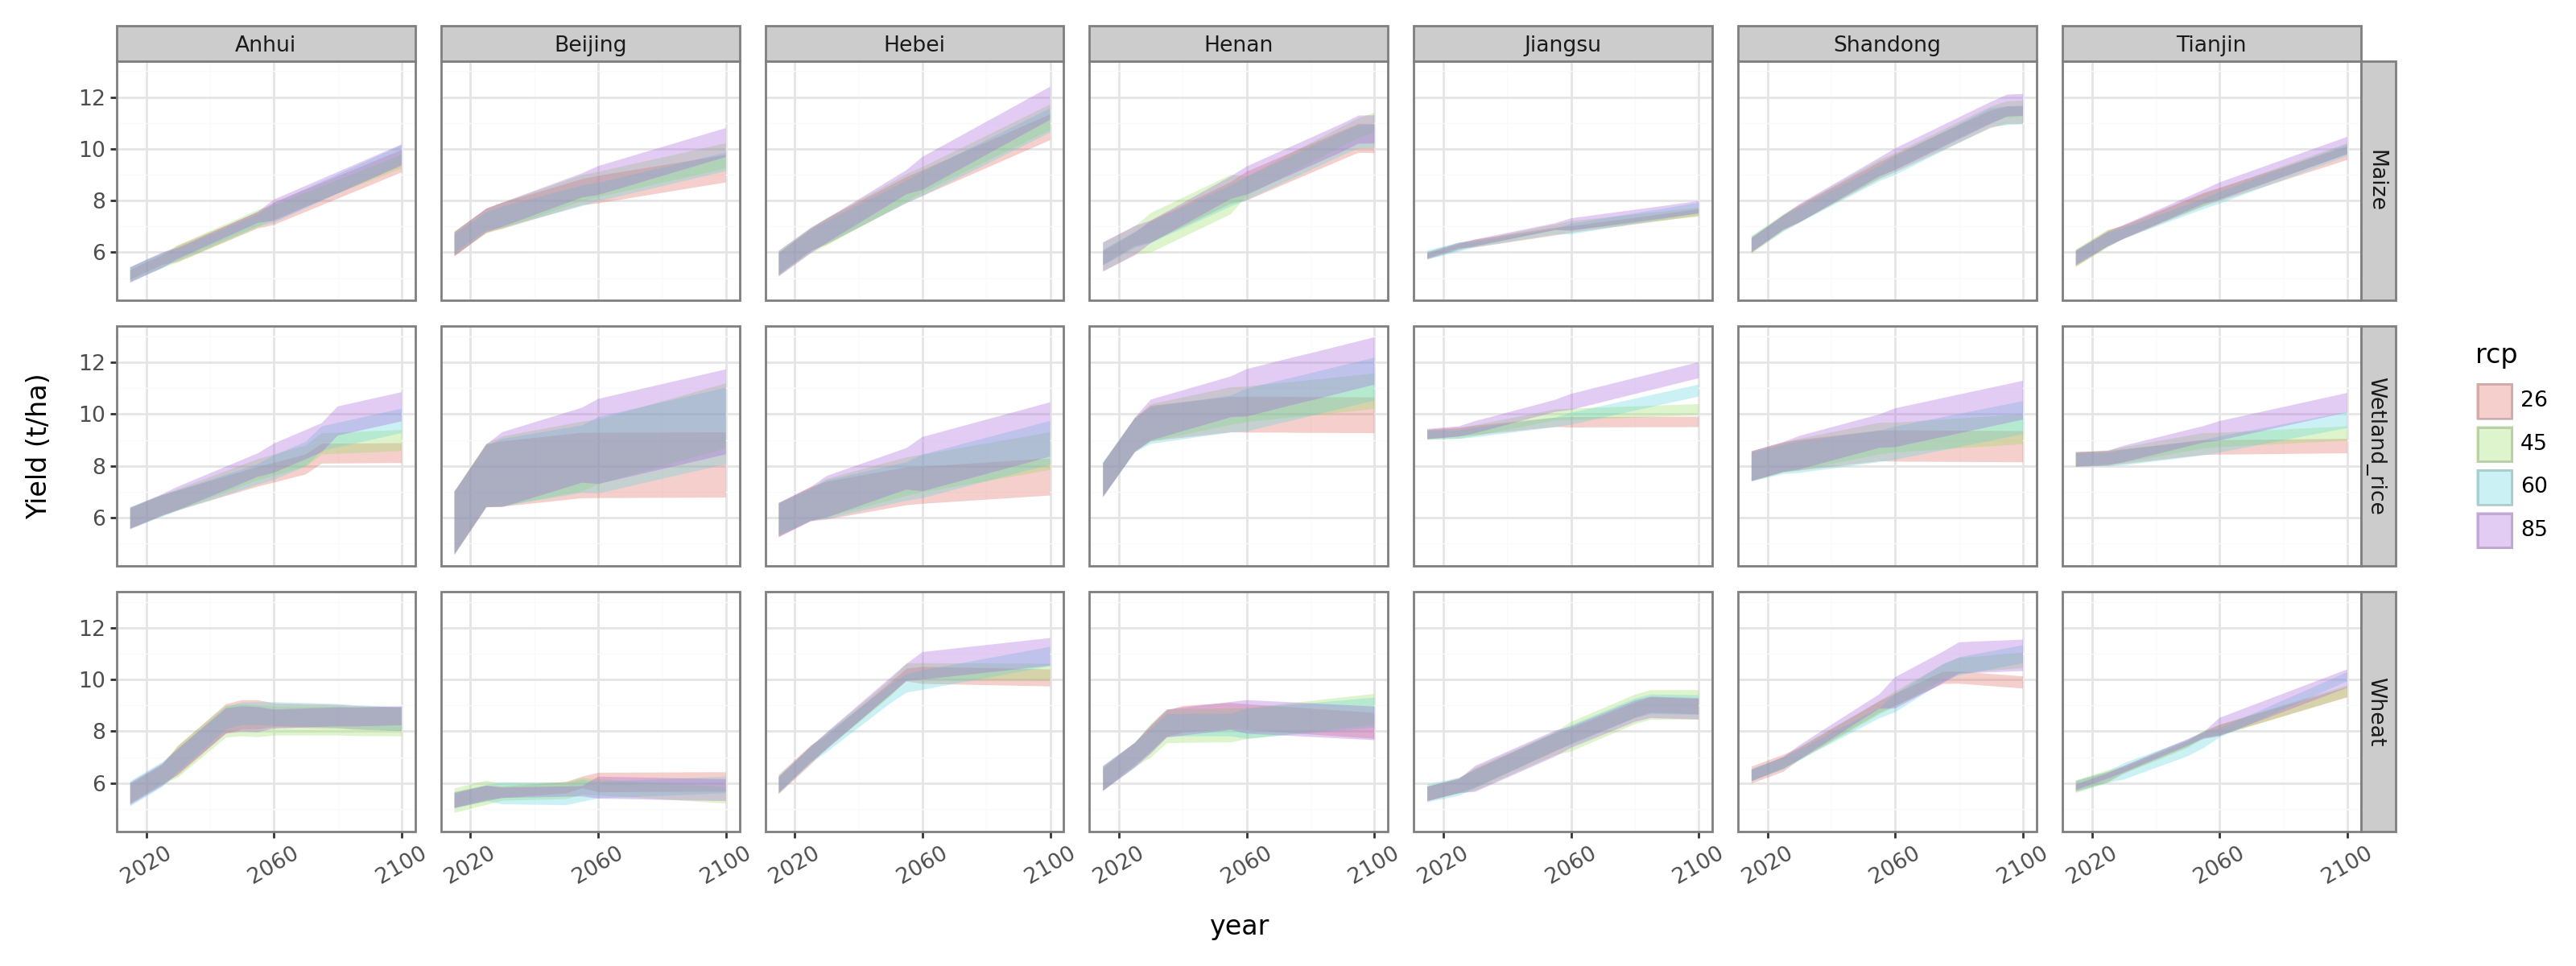

In [9]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 # BAU crop yield
 geom_ribbon(Scenario_BAU_yield_img_area_weighted_mean_df, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.3) +
 facet_grid('crop~Province') +
 theme_bw(base_size=12) + 
 theme(axis_text_x=element_text(rotation=30)) +
 scale_x_continuous(breaks=range(1980,2101,40)) +
 ylab('Yield (t/ha)')
)

### Compute the total grain production

In [10]:
# merge yield with area
yield_with_area = pd.merge(Scenario_BAU_yield_img, future_harvested_area, on=['crop','water','year'])

In [11]:
def compute_total_prod(in_df):
  print(' ',end='',flush=True)

  out_dfs = []

  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    crop = row['crop']
    water = row['water']
    rcp = row['rcp']
    ssp = row['SSP']
    year = row['year']
    
    prod_img = row['future_farmland_area'].select('final_area_kha').multiply(row['img_future'])
    stats = prod_img.reduceRegions(collection=NCP_provinces,scale=GAEZ_pix_scale,reducer='sum').getInfo()['features']

    stats_df = pd.DataFrame({i['properties']['NAME']:[i['properties']['sum']] for i in stats}).T.reset_index()
    stats_df.columns = ['Province','production_pred']

    stats_df['crop'] = crop
    stats_df['water'] = water
    stats_df['ssp'] = ssp
    stats_df['rcp'] = rcp
    stats_df['year'] = year
    stats_df['production_pred'] = stats_df['production_pred'] * 1_000

    out_dfs.append(stats_df)

  return pd.concat(out_dfs).reset_index(drop=True)


In [12]:
# # get the crop production for each province
# historical_production = parallelize_dataframe(yield_with_area,compute_total_prod,60)
# production_pred = historical_production.groupby(['Province','crop','year','ssp','rcp']).sum().reset_index()
# production_pred.to_csv(f'./result_csv/production_pred.csv',index=False)

production_pred = pd.read_csv(f'./result_csv/production_pred.csv')

In [13]:
# get the yearbook production records
out_dfs = []
for k,v in crop_dict.items():
  df = pd.read_csv(f'{yearbook_path}/production_{k}.csv')
  df = df.set_index('地区').stack().reset_index()
  df.columns = ['Province','year','production_yearbook']
  df['production_yearbook'] = df['production_yearbook'] * 10_000
  df['year'] = df['year'].astype(int)
  df['crop'] = v
  out_dfs.append(df)

yearbook_production = pd.concat(out_dfs).reset_index(drop=True)

In [21]:
# merge pred and yearbook
prod_merge = production_pred.merge(yearbook_production).reset_index(drop=True)

# convert the production to million tons
prod_merge['production_pred'] = prod_merge['production_pred']/1e6
prod_merge['production_yearbook'] = prod_merge['production_yearbook']/1e6

straight_line = pd.DataFrame({'x':np.linspace(0,prod_merge['production_pred'].max(),10),
                 'y':np.linspace(0,prod_merge['production_pred'].max(),10)})

prod_merge = prod_merge.replace(city_cn_en)

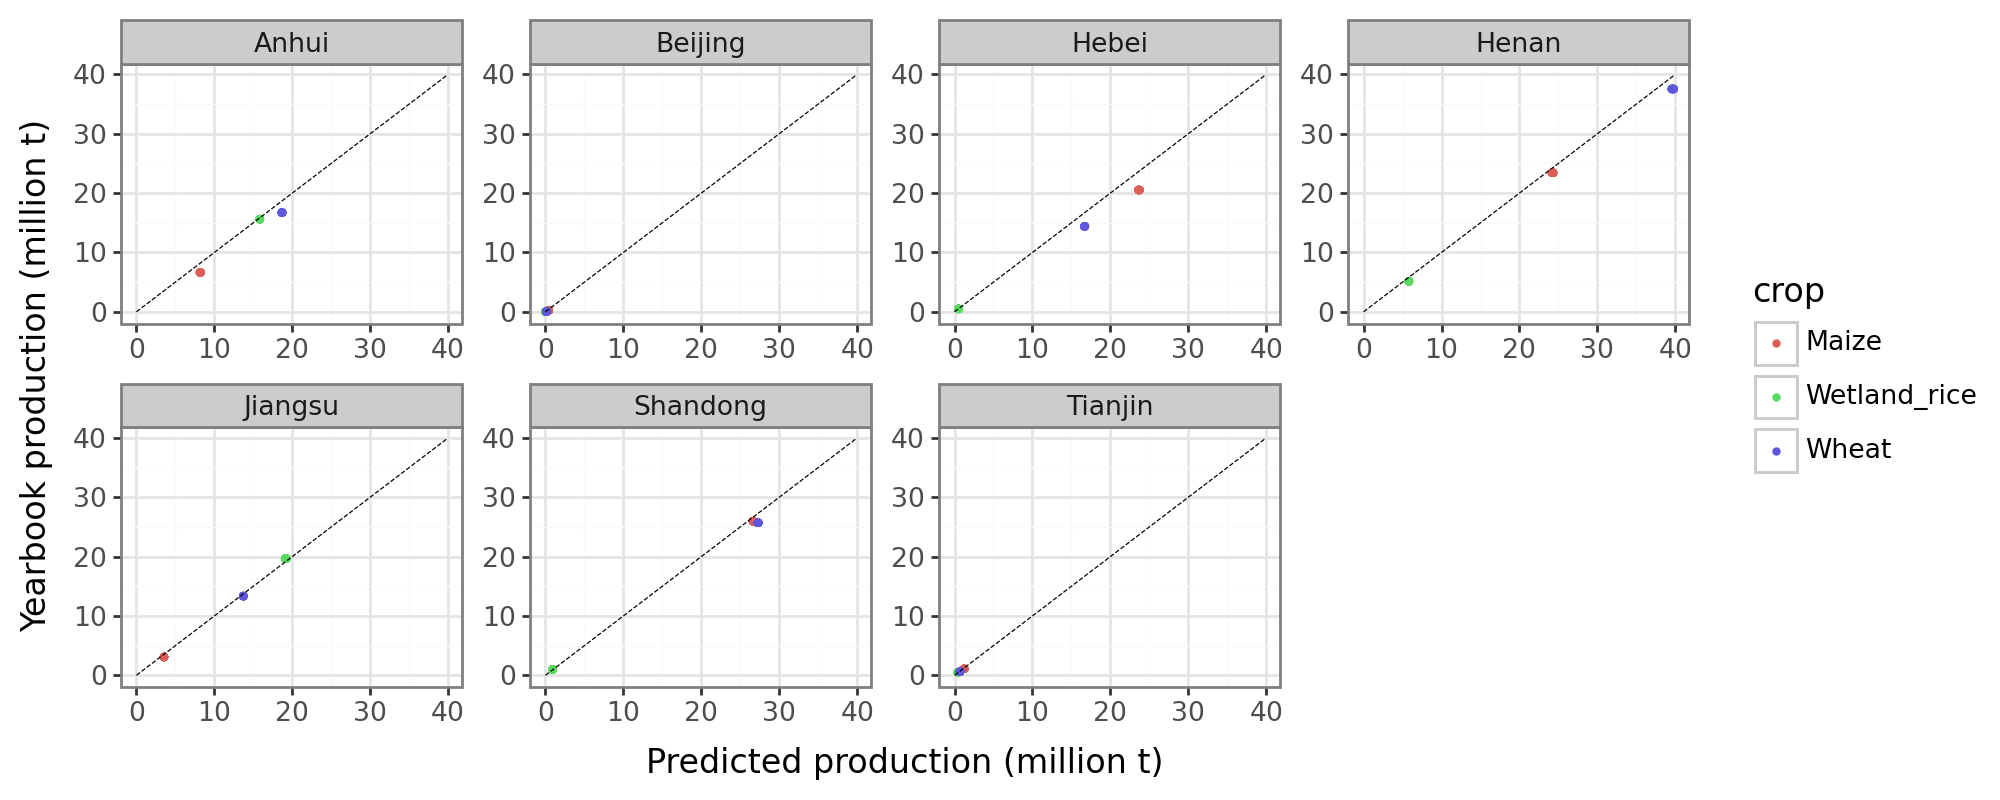

In [22]:
# plot their comparision
plotnine.options.figure_size = (10, 4)
plotnine.options.dpi = 100

(ggplot() 
+ geom_point(prod_merge,aes(x='production_pred',y='production_yearbook',color='crop'),size=0.7)
+ geom_line(straight_line,aes(x='x',y='y'),size=0.25,linetype='dashed')
+ facet_wrap(['Province'],nrow=2,scales='free')
+ theme_bw(base_size=12)
+ xlab('Predicted production (million t)')
+ ylab('Yearbook production (million t)')
)

### Compute the food production from 
- Technology, 
- climate change,
- urbanization, 
- Cropland increase

Illustration for the stack change plot

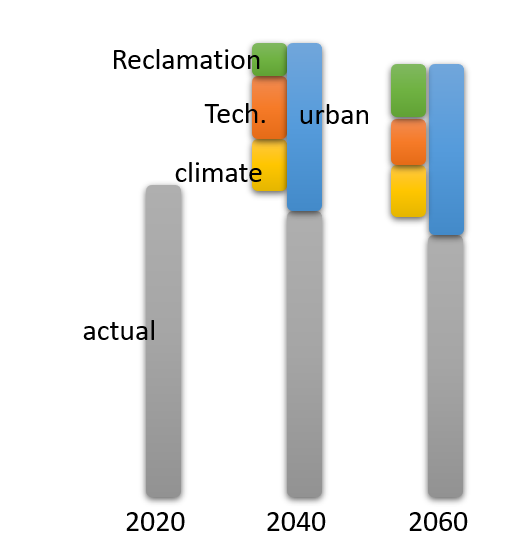

Illustration for the rectagle figure

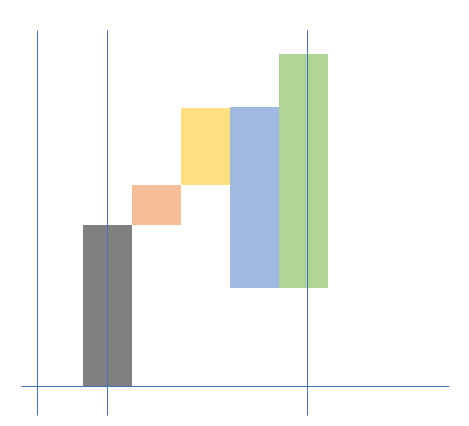

#### step_1): get the final_pred production: 
- coreponding to the grey columns in above figure
- pred_actual_production = future_harvested_area * BAU_crop_yield

In [16]:
# function to calculate the confidence interval between two multiply sets
def cal_std(mean_A, mean_b, ci_a, ci_b):
    # Ensure the inputs are in GEE format
    mean_A = ee.Image(mean_A)
    mean_b = ee.Image(mean_b)
    ci_a = ee.Image(ci_a)
    ci_b = ee.Image(ci_b)

    # Perform the calculation using GEE methods
    # std_AB = (mean_A**2 + std_A**2) * (mean_B**2 + std_B**2) - mean_A**2 * mean_B**2
    result = mean_A.pow(2).add(ci_a.pow(2)).multiply(mean_b.pow(2).add(ci_b.pow(2))).subtract(mean_A.pow(2).multiply(mean_b.pow(2)))

    return result

In [14]:
pred_actual_production = future_harvested_area.merge(Scenario_BAU_yield_img)
pred_actual_production['production'] = pred_actual_production.apply(lambda row:row['img_future']\
                       .multiply(row['future_farmland_area'].select('final_area_kha')),1)

pred_actual_production['production_sd'] = pred_actual_production.apply(lambda row:cal_std(
    row['future_farmland_area'].select('final_area_kha'),
    row['img_future'],
    row['future_farmland_area'].select('final_area_kha_top').subtract(row['future_farmland_area'].select('final_area_kha')),
    row['img_future_sd']),1)

pred_actual_production.head()

In [ ]:
def compute_actual_crop_production(in_df,in_shp=NCP_provinces,name='EN_Name'):
  # hack to show process bar in multi-processing module
  print(' ',end='',flush=True)

  df_list = []
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    crop = row['crop']
    water = row['water']
    year = row['year']
    rcp = row['rcp']
    ssp = row['SSP']

    production_img = row['production']
    production_img_sd = row['production_sd']

    in_img = ee.Image([production_img,production_img_sd]).rename(['val','sd'])

    stats = in_img.reduceRegions(collection = in_shp, reducer = 'sum', scale = GAEZ_pix_scale).getInfo()
    stats_df = pd.DataFrame({i['properties'][name]:[i['properties']['val']] for i in stats['features']}).T.reset_index()
    stats_df['sd'] = [i['properties']['sd'] for i in stats['features']]

    # append infomation
    stats_df.columns = ['Province','Total Production','Total Production sd']
    stats_df['crop'] = crop
    stats_df['water'] = water
    stats_df['year'] = year
    stats_df['rcp'] = rcp
    stats_df['ssp'] = ssp

     # store df                        
    df_list.append(stats_df)

  # concat dfs
  out_df = pd.concat(df_list,ignore_index=True)
  
  return out_df

In [17]:
# # get the total production for each ['crop','water','rcp','ssp','year','province']
# pred_actual_production_df = parallelize_dataframe(pred_actual_production,compute_actual_crop_production,60)
# pred_actual_production_df.to_csv(f'./result_csv/pred_actual_production_df.csv',index=False)

pred_actual_production_df = pd.read_csv(f'./result_csv/pred_actual_production_df.csv')

In [70]:
# get the total production for each ['rcp','ssp','year']
pred_actual_production_sum_df = pred_actual_production_df.groupby(['rcp','ssp','year']).sum(numeric_only=True).reset_index()

# compute coordinates for rectangle plot
pred_actual_production_sum_df['actual_x_min'] = pred_actual_production_sum_df['year'] - 5/8
pred_actual_production_sum_df['actual_x_max'] = pred_actual_production_sum_df['year'] + 5/8
pred_actual_production_sum_df['actual_y_min'] = 0
pred_actual_production_sum_df['actual_y_max'] = pred_actual_production_sum_df['Total Production']

pred_actual_production_sum_df['color_final'] = 'Final'

pred_actual_production_sum_df.to_csv(f'./result_csv/pred_actual_production_sum_df.csv',index=False)

In [71]:
# select ssp/rcp for ploting
pred_actual_select = pred_actual_production_sum_df >> mask(X.rcp == 45, X.ssp=='SSP3')

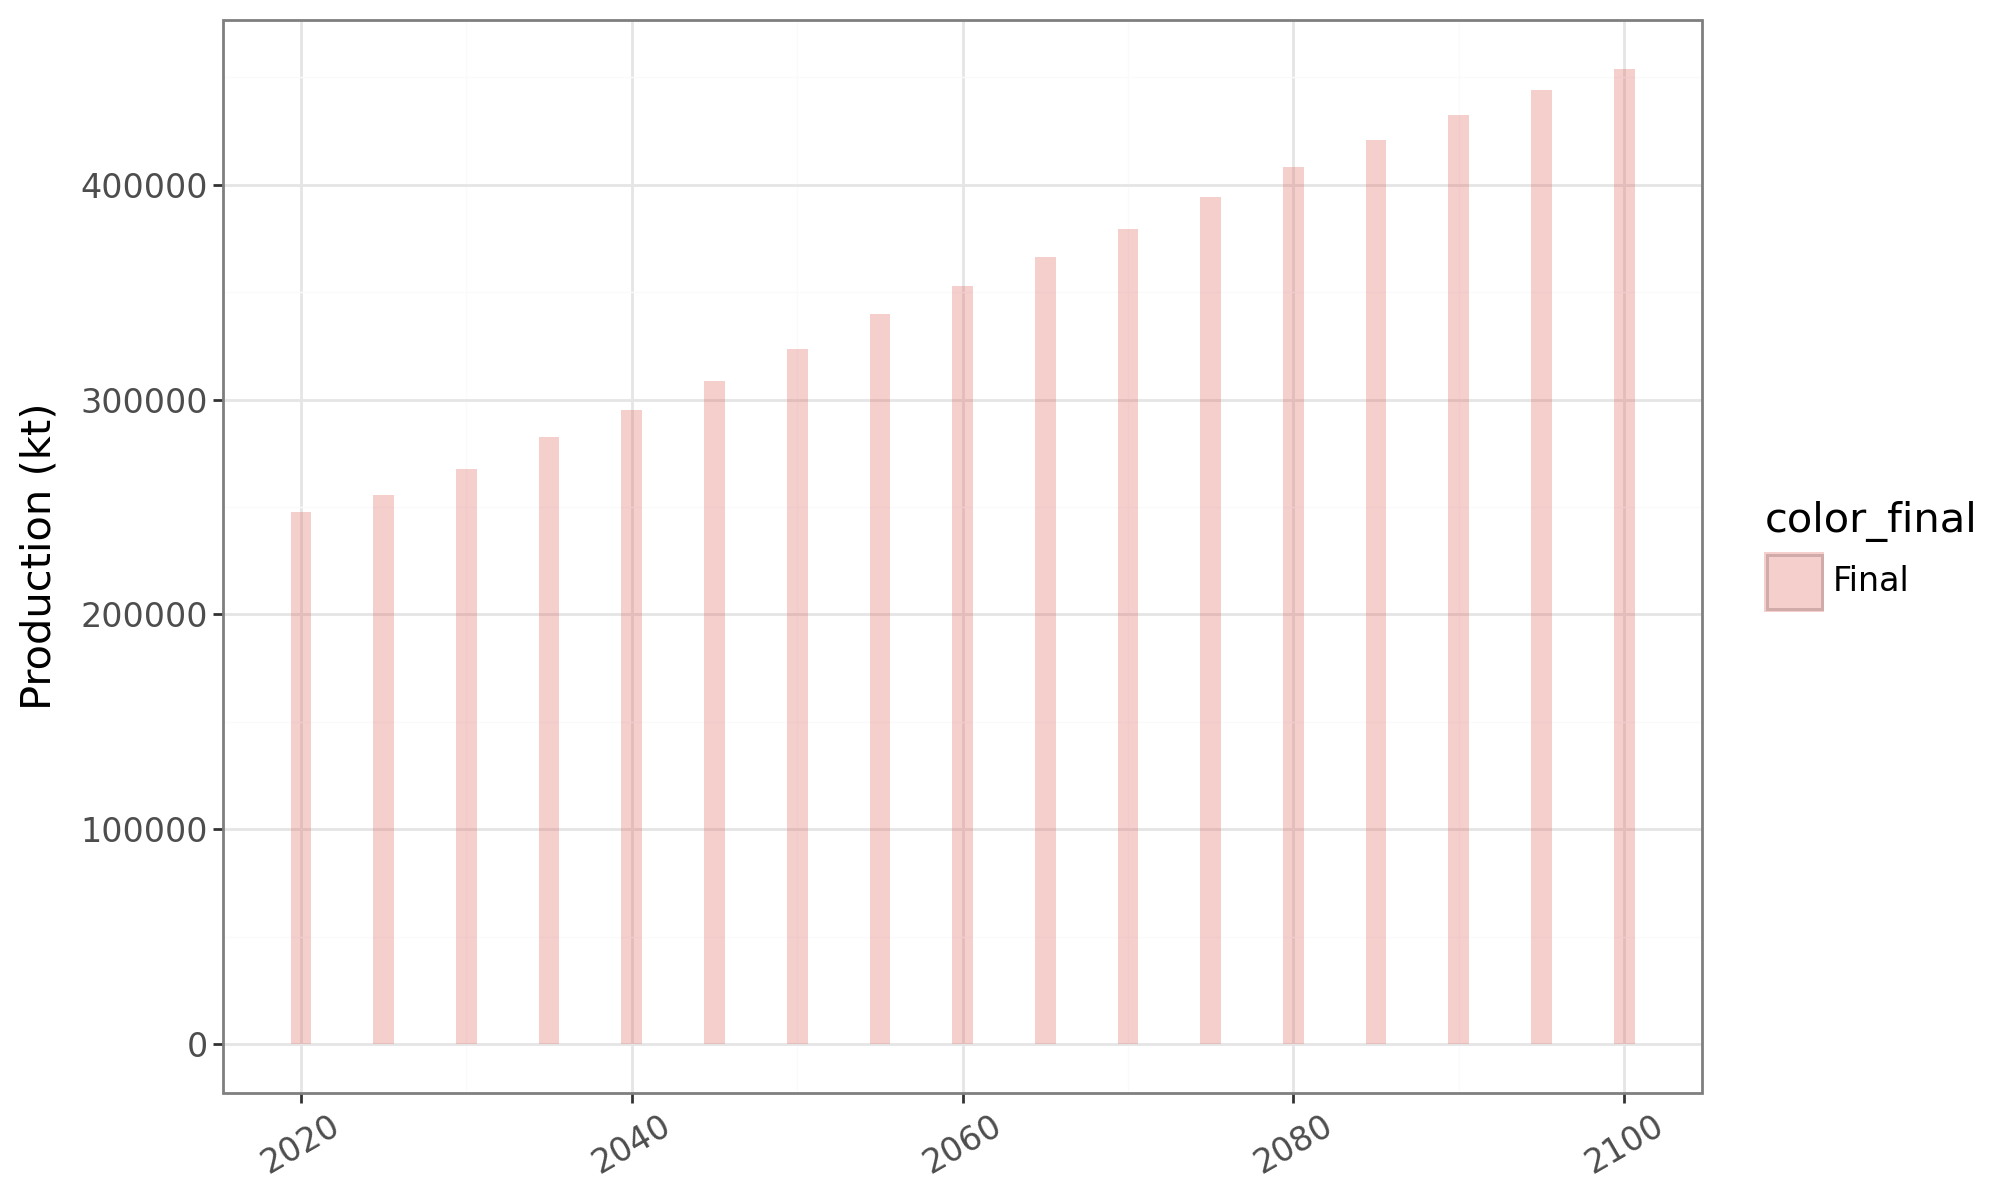

In [72]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (10, 6)
plotnine.options.dpi = 100

(ggplot() +
 # final production
 geom_rect(pred_actual_select, aes(xmin='actual_x_min',xmax='actual_x_max',
                  ymin='actual_y_min',ymax='actual_y_max',fill='color_final'),alpha=0.3) +
 theme_bw(base_size=15) + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Production (kt)')
)

#### step_2): compute the rcp (climate) change:
- coreponding to the yellow bar
- climate_production = yiled_propagated_by_rcp * future_harvested_area

In [73]:
# filter records that are >= 2020
yiled_propagated_by_rcp = GAEZ_actual_yield_propogated >> mask(X.rcp != 'Historical', X.year >=2020)

# IMPORTANT! remember to sort the df so that it mathes the result after groupby
yiled_propagated_by_rcp = yiled_propagated_by_rcp.sort_values(['crop','water','rcp','year'])

# append the lag_year record (e.g 2025 to 2020)
yiled_propagated_by_rcp['lag_yield'] = yiled_propagated_by_rcp.groupby(['crop','water','rcp'])\
                      .apply(lambda df,idx:df['propogated_yield'].shift(-1),1)\
                      .reset_index()['propogated_yield'].tolist()

yiled_propagated_by_rcp['lag_yield_sd'] = yiled_propagated_by_rcp.groupby(['crop','water','rcp'])\
                      .apply(lambda df,idx:df['img_future_sd'].shift(-1),1)\
                      .reset_index()['img_future_sd'].tolist()

# merge with harvested area
climate_production_gap = yiled_propagated_by_rcp.merge(future_harvested_area).dropna()

C:\Users\Jinzhu\AppData\Local\Temp\ipykernel_12120\3018739749.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\Jinzhu\AppData\Local\Temp\ipykernel_12120\3018739749.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [74]:
def compute_climate_production(in_df,in_shp = NCP_provinces,name='EN_Name'):
  # hack to show process bar in multi-processing module
  print(' ',end='',flush=True)

  df_list = []
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    crop = row['crop']
    water = row['water']
    year = row['year']
    rcp = row['rcp']
    ssp = row['SSP']

    gap_yield = row['lag_yield'].subtract(row['propogated_yield'])
    gap_yield_sd = row['lag_yield_sd']
    
    future_area = row['future_farmland_area'].select('final_area_kha')
    future_area_sd = row['future_farmland_area'].select('final_area_kha_top').subtract(row['future_farmland_area'].select('final_area_kha'))

    gap_production = gap_yield.multiply(future_area)
    gap_production_sd = cal_std(gap_yield,future_area,gap_yield_sd,future_area_sd)

    in_img = ee.Image([gap_production,gap_production_sd]).rename(['val','sd'])

    stats = in_img.reduceRegions(collection = in_shp, reducer = 'sum', scale = GAEZ_pix_scale).getInfo()
    stats_df = pd.DataFrame({i['properties'][name]:[i['properties']['val']] for i in stats['features']}).T.reset_index()
    stats_df['sd'] = [i['properties']['sd'] for i in stats['features']]

    # append infomation
    stats_df.columns=['Province','Gap Production','Gap Production sd']
    stats_df['crop'] = crop
    stats_df['water'] = water
    stats_df['year'] = year
    stats_df['rcp'] = rcp
    stats_df['ssp'] = ssp

    # store df                        
    df_list.append(stats_df)

  # concat dfs
  out_df = pd.concat(df_list,ignore_index=True)
  
  return out_df

In [75]:
# # get the total production for each ['crop','water','rcp','year','province']
# climate_production_df = parallelize_dataframe(climate_production_gap,compute_climate_production,60)
# climate_production_df.to_csv(f'./result_csv/climate_production_df.csv',index=False)

# # # get the total production for each ['rcp','ssp','year']
# climate_production_sum_df = climate_production_df.groupby(['rcp','ssp','year']).sum(numeric_only=True).reset_index()
# climate_production_sum_df.to_csv(f'./result_csv/climate_production_sum_df.csv',index=False)

climate_production_df = pd.read_csv(f'./result_csv/climate_production_df.csv')
climate_production_sum_df = pd.read_csv(f'./result_csv/climate_production_sum_df.csv')

In [76]:
# compute coordinates for rectangle plot
prod_actual_with_climate = pred_actual_production_sum_df.merge(climate_production_sum_df)

prod_actual_with_climate['climate_x_min'] = prod_actual_with_climate['year'] + 5/8*1
prod_actual_with_climate['climate_x_max'] = prod_actual_with_climate['year'] + 5/8*3
prod_actual_with_climate['climate_y_min'] = prod_actual_with_climate['Total Production']
prod_actual_with_climate['climate_y_max'] = prod_actual_with_climate['Total Production'] \
                        + prod_actual_with_climate['Gap Production']
# rename the gap production to climate_gap
prod_actual_with_climate = prod_actual_with_climate >> rename(gap_climate='Gap Production')
prod_actual_with_climate = prod_actual_with_climate >> rename(gap_climate_sd='Gap Production sd')

In [77]:
# filter for plot
prod_actual_with_climate_select = prod_actual_with_climate >> mask(X.rcp == 45, X.ssp=='SSP3')
prod_actual_with_climate_select.head()

,rcp,ssp,year,Total Production,Total Production sd,actual_x_min,actual_x_max,actual_y_min,actual_y_max,color_final,gap_climate,gap_climate_sd,climate_x_min,climate_x_max,climate_y_min,climate_y_max
110,45,SSP3,2020,247744.450835,15483.156719,2019.375,2020.625,0,247744.450835,Final,-375.785035,8689.921577,2020.625,2021.875,247744.450835,247368.665800
111,45,SSP3,2025,255709.214507,21983.694588,2024.375,2025.625,0,255709.214507,Final,1569.646943,8326.967790,2025.625,2026.875,255709.214507,257278.861450
112,45,SSP3,2030,267855.998684,39988.927925,2029.375,2030.625,0,267855.998684,Final,1559.564936,8119.630930,2030.625,2031.875,267855.998684,269415.563620
113,45,SSP3,2035,282661.872460,50004.321229,2034.375,2035.625,0,282661.872460,Final,1566.653762,8077.644733,2035.625,2036.875,282661.872460,284228.526222
114,45,SSP3,2040,294997.173345,63868.047913,2039.375,2040.625,0,294997.173345,Final,1582.367851,8121.724627,2040.625,2041.875,294997.173345,296579.541196


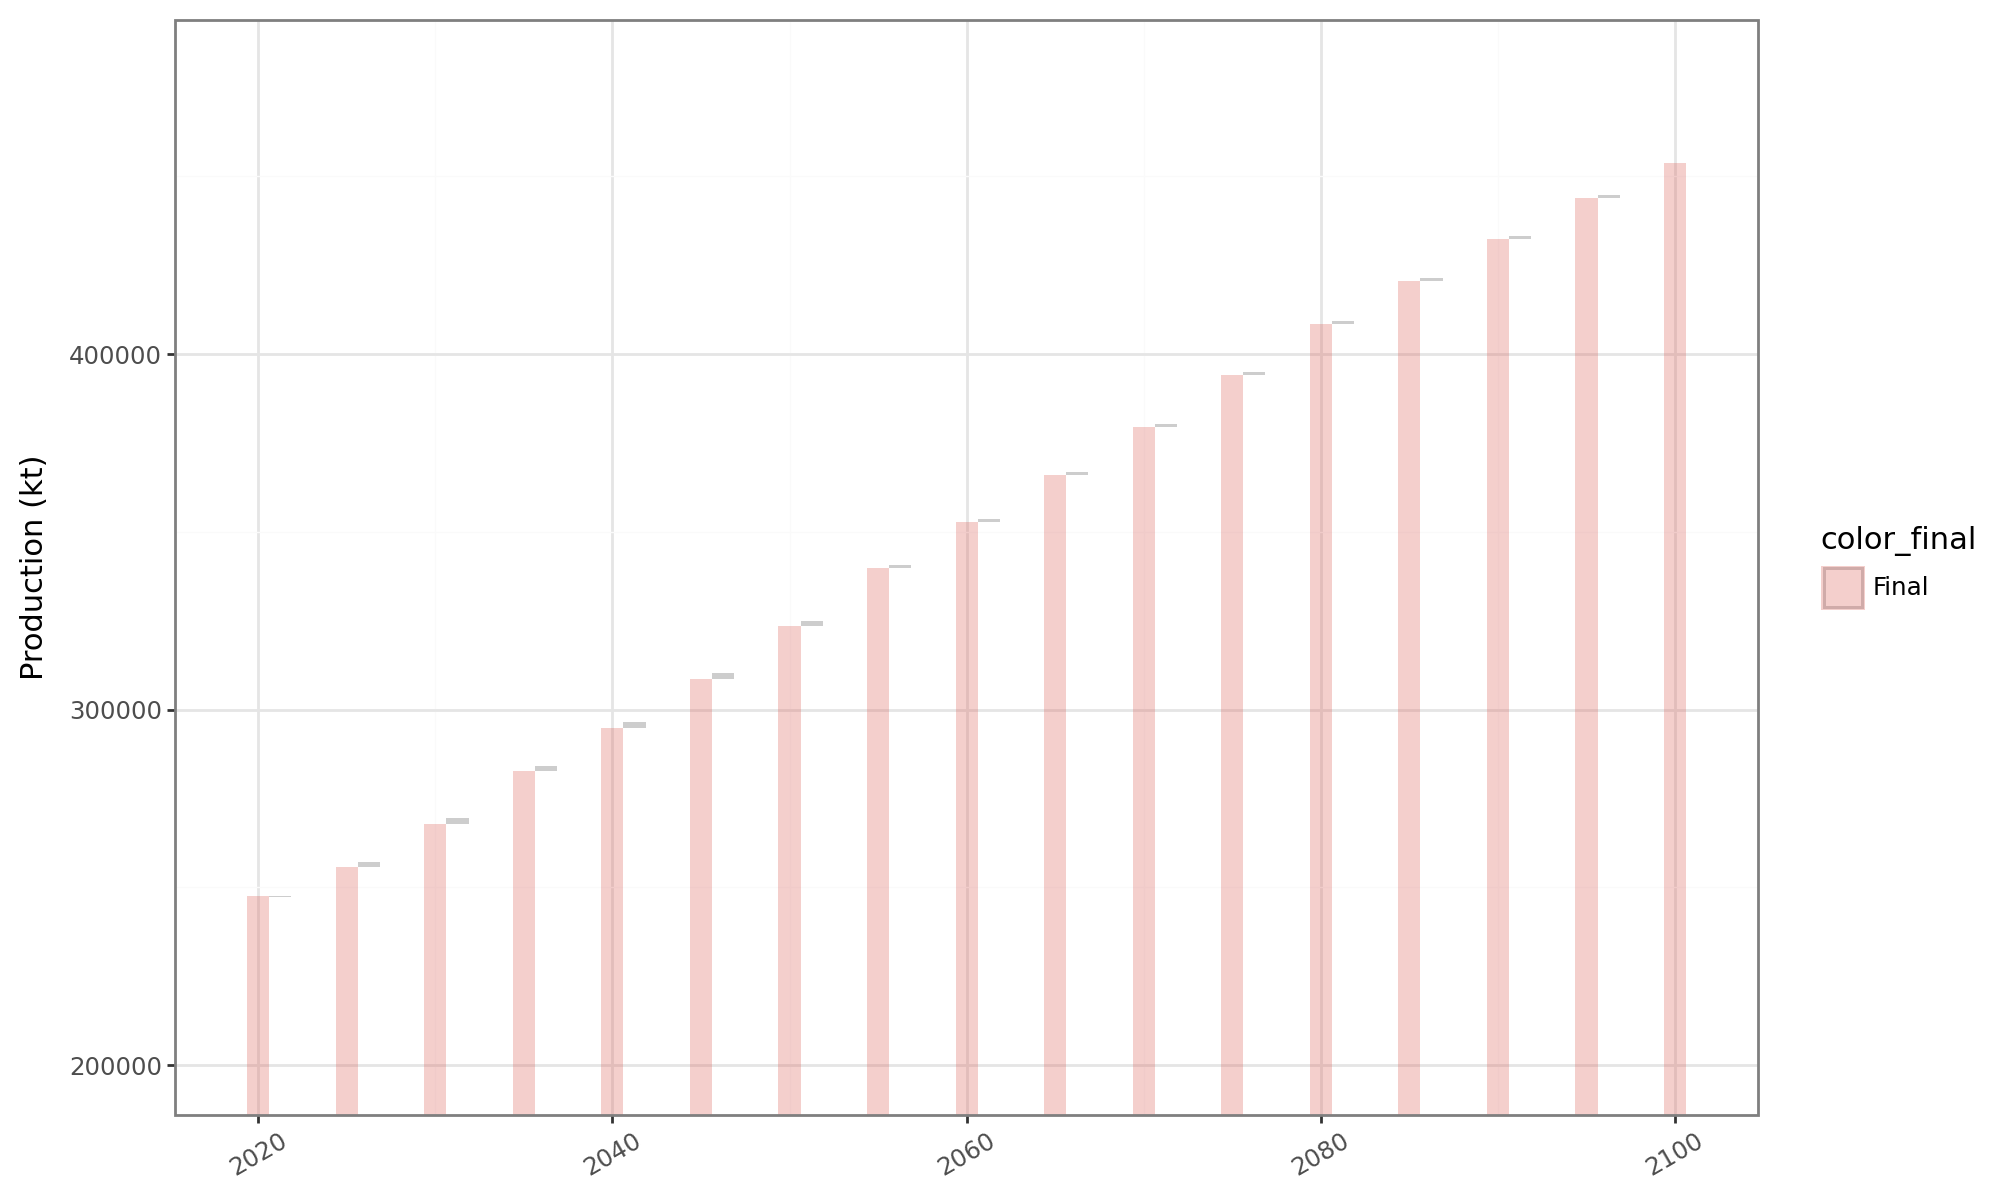

In [78]:
# plot the climate_change induced crop production change
plotnine.options.figure_size = (10, 6)
plotnine.options.dpi = 100

(ggplot() +
 # final production
 geom_rect(pred_actual_select, aes(xmin='actual_x_min',xmax='actual_x_max',
                  ymin='actual_y_min',ymax='actual_y_max',fill='color_final'),alpha=0.3) +
 # climate production gap
 geom_rect(prod_actual_with_climate_select, aes(xmin='climate_x_min',xmax='climate_x_max',
                        ymin='climate_y_min',ymax='climate_y_max'),alpha=0.3) +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 coord_cartesian(ylim=(200000,480000)) +
 ylab('Production (kt)')
)

#### step_3): compute the technology production change
- coresponding to the orange columns
- tech_production = yield_BAU * harvsted_area_2010

In [79]:
# the BAU_yield = climate_yield +  tech_yield,
# so, tech_yield = BAU_yield - climate_yield
yiled_BAU_by_tech = GAEZ_actual_yield_propogated.merge(Scenario_BAU_yield_img,on=['crop','water','year','rcp'])
yiled_BAU_by_tech = yiled_BAU_by_tech >> drop('img_future_sd_x') >> rename(img_future_sd='img_future_sd_y')
yiled_BAU_by_tech = yiled_BAU_by_tech >> mask(X.rcp != 'Historical', X.year >=2020)
yiled_BAU_by_tech['yield_tech_advance'] = yiled_BAU_by_tech.apply(lambda row:row['img_future'].subtract(row['propogated_yield']),1)

# IMPORTANT! remember to sort values so that the order mathes the order after groupby
yiled_BAU_by_tech = yiled_BAU_by_tech.sort_values(['crop','water','rcp','year'])

# append the lag_year record (e.g 2025 to 2020)
yiled_BAU_by_tech['lag_yield'] = yiled_BAU_by_tech.groupby(['crop','water','rcp'])\
                      .apply(lambda df,idx:df['yield_tech_advance'].shift(-1),1)\
                      .reset_index()['yield_tech_advance'].tolist()

yiled_BAU_by_tech['lag_yield_sd'] = yiled_BAU_by_tech.groupby(['crop','water','rcp'])\
                      .apply(lambda df,idx:df['img_future_sd'].shift(-1),1)\
                      .reset_index()['img_future_sd'].tolist()

# merge with harvested area
tech_production_gap = yiled_BAU_by_tech.merge(future_harvested_area).dropna()

C:\Users\Jinzhu\AppData\Local\Temp\ipykernel_12120\1173007194.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\Jinzhu\AppData\Local\Temp\ipykernel_12120\1173007194.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [80]:
def compute_tech_production(in_df,in_shp = NCP_provinces,name='EN_Name'):
  # hack to show process bar in multi-processing module
  print(' ',end='',flush=True)

  df_list = []
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    crop = row['crop']
    water = row['water']
    year = row['year']
    rcp = row['rcp']
    ssp = row['SSP']
    
    gap_yield = row['lag_yield'].subtract(row['yield_tech_advance'])
    gap_yield_sd = row['lag_yield_sd']
    
    future_area = row['future_farmland_area'].select('final_area_kha')
    future_area_sd = row['future_farmland_area'].select('final_area_kha_top').subtract(row['future_farmland_area'].select('final_area_kha'))

    gap_production = gap_yield.multiply(future_area)
    gap_production_sd = cal_std(gap_yield,future_area,gap_yield_sd,future_area_sd)

    in_img = ee.Image([gap_production,gap_production_sd]).rename(['val','sd'])

    stats = in_img.reduceRegions(collection = in_shp, reducer = 'sum', scale = GAEZ_pix_scale).getInfo()
    stats_df = pd.DataFrame({i['properties'][name]:[i['properties']['val']] for i in stats['features']}).T.reset_index()
    stats_df['sd'] = [i['properties']['sd'] for i in stats['features']]

    # append infomation
    stats_df.columns=['Province','Gap Production','Gap Production sd']
    stats_df['crop'] = crop
    stats_df['water'] = water
    stats_df['year'] = year
    stats_df['rcp'] = rcp
    stats_df['ssp'] = ssp

    # store df                        
    df_list.append(stats_df)

  # concat dfs
  out_df = pd.concat(df_list,ignore_index=True)
  
  return out_df

In [81]:
# # get the total production for each ['crop','water','rcp','year','province']
# tech_production_df = parallelize_dataframe(tech_production_gap,compute_tech_production,60)
# tech_production_df.to_csv(f'./result_csv/tech_production_df.csv',index=False)

# # get the total production for each ['rcp','ssp','year']
# tech_production_df_sum_df = tech_production_df.groupby(['rcp','ssp','year']).sum(numeric_only=True).reset_index()
# tech_production_df_sum_df['rcp'] = tech_production_df_sum_df['rcp'].astype(int)
# tech_production_df_sum_df.to_csv(f'./result_csv/tech_production_df_sum_df.csv',index=False)

tech_production_df = pd.read_csv(f'./result_csv/tech_production_df.csv')
tech_production_df_sum_df = pd.read_csv(f'./result_csv/tech_production_df_sum_df.csv')

In [83]:
# merge tech_gap with climate and actual production
prod_actual_with_climate_tech = (prod_actual_with_climate >> drop(['Total Production']))\
                  .merge(tech_production_df_sum_df,on=['rcp','ssp','year'])

# compute the crop production induced by technology advance
prod_actual_with_climate_tech['tech_x_min'] = prod_actual_with_climate_tech['year'] + 5/8*3
prod_actual_with_climate_tech['tech_x_max'] = prod_actual_with_climate_tech['year'] + 5/8*5
prod_actual_with_climate_tech['tech_y_min'] = prod_actual_with_climate_tech['climate_y_max']
prod_actual_with_climate_tech['tech_y_max'] = prod_actual_with_climate_tech['climate_y_max'] \
                        + prod_actual_with_climate_tech['Gap Production']

# rename the gap production to gap_tech
prod_actual_with_climate_tech = prod_actual_with_climate_tech >> rename(gap_tech='Gap Production')
prod_actual_with_climate_tech = prod_actual_with_climate_tech >> rename(gap_tech_sd='Gap Production sd')

In [84]:
# filter for plot
prod_actual_with_climate_tech_select = prod_actual_with_climate_tech >> mask(X.rcp == 45, X.ssp=='SSP3')
prod_actual_with_climate_tech_select.head()

,rcp,ssp,year,Total Production sd,actual_x_min,actual_x_max,actual_y_min,actual_y_max,color_final,gap_climate,...,climate_x_min,climate_x_max,climate_y_min,climate_y_max,gap_tech,gap_tech_sd,tech_x_min,tech_x_max,tech_y_min,tech_y_max
110,45,SSP3,2020,15483.156719,2019.375,2020.625,0,247744.450835,Final,-375.785035,...,2020.625,2021.875,247744.450835,247368.665800,11651.996362,8693.228481,2021.875,2023.125,247368.665800,259020.662162
111,45,SSP3,2025,21983.694588,2024.375,2025.625,0,255709.214507,Final,1569.646943,...,2025.625,2026.875,255709.214507,257278.861450,11986.154057,17555.613998,2026.875,2028.125,257278.861450,269265.015506
112,45,SSP3,2030,39988.927925,2029.375,2030.625,0,267855.998684,Final,1559.564936,...,2030.625,2031.875,267855.998684,269415.563620,12110.883529,17318.186791,2031.875,2033.125,269415.563620,281526.447149
113,45,SSP3,2035,50004.321229,2034.375,2035.625,0,282661.872460,Final,1566.653762,...,2035.625,2036.875,282661.872460,284228.526222,8263.257707,17327.606814,2036.875,2038.125,284228.526222,292491.783929
114,45,SSP3,2040,63868.047913,2039.375,2040.625,0,294997.173345,Final,1582.367851,...,2040.625,2041.875,294997.173345,296579.541196,8332.117795,17494.294318,2041.875,2043.125,296579.541196,304911.658991


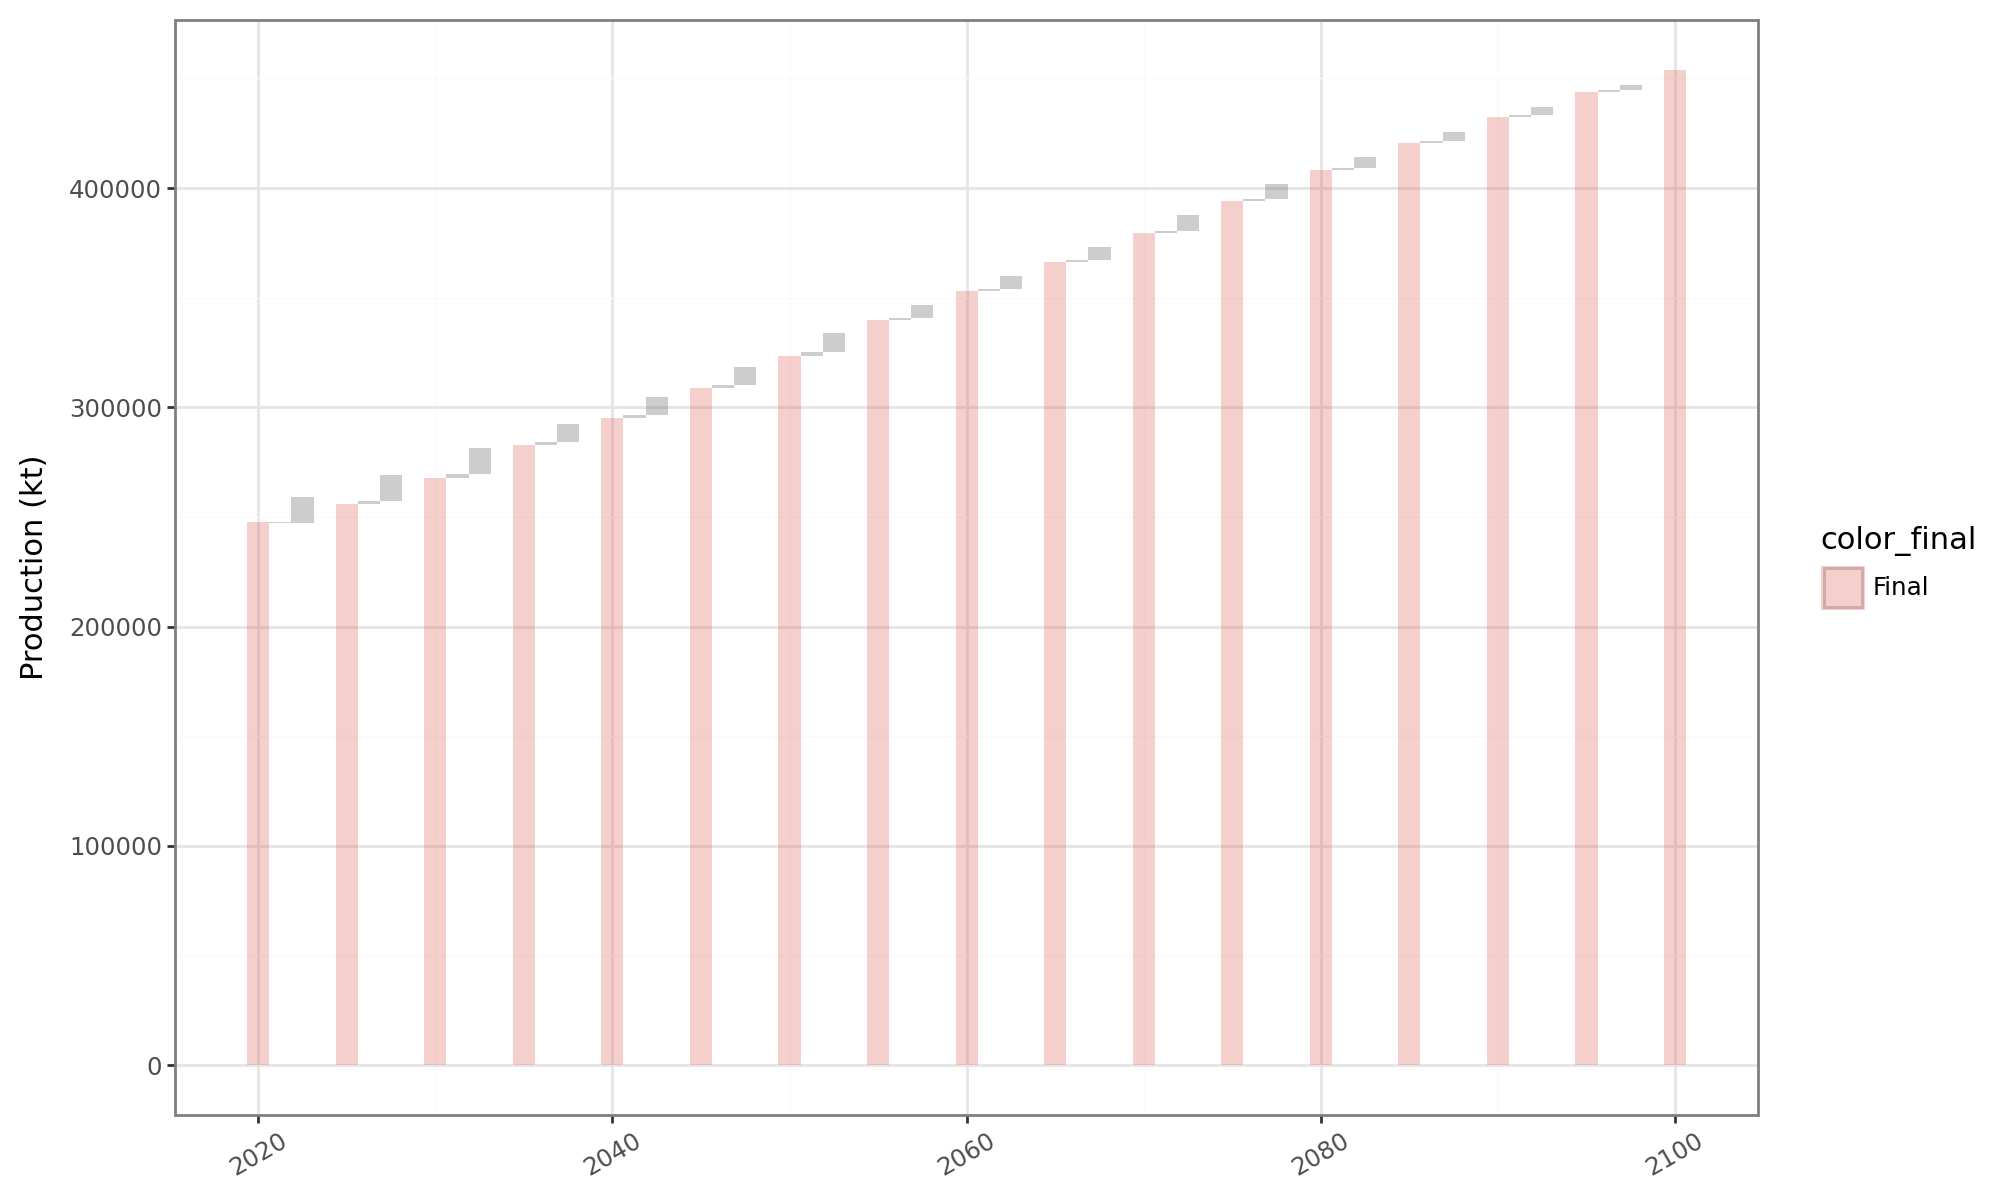

In [85]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (10, 6)
plotnine.options.dpi = 100

(ggplot() +
 # final production
 geom_rect(pred_actual_select, aes(xmin='actual_x_min',xmax='actual_x_max',
                  ymin='actual_y_min',ymax='actual_y_max',fill='color_final'),alpha=0.3) +
 # climate production gap
 geom_rect(prod_actual_with_climate_select, aes(xmin='climate_x_min',xmax='climate_x_max',
                        ymin='climate_y_min',ymax='climate_y_max'),alpha=0.3) +
 # tech gap
 geom_rect(prod_actual_with_climate_tech_select, aes(xmin='tech_x_min',xmax='tech_x_max',
                           ymin='tech_y_min',ymax='tech_y_max'),alpha=0.3) +
#  coord_cartesian(ylim=(200000,380000)) +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Production (kt)')
)

#### step_4): compute the reclamation that increases the crop production

In [86]:
# compute the 95% confidence interval
reclamation_area_gap = reclamation_each_pix_mosaic.copy()
reclamation_area_gap = reclamation_area_gap >> mask(X.year >= 2020)
reclamation_area_gap['pix_increase_kha_img_sd'] = reclamation_area_gap\
      .apply(lambda row: ee.Image(row['pix_increase_kha_img_top']).subtract(ee.Image(row['pix_increase_kha_img_bot'])),1) 

# make sure the year is in range(2000,2101,5)
reclamation_area_gap = reclamation_area_gap >> mask(X.year.isin(range(2000,2101,5)))

# append the lag_year record (e.g 2025 to 2020)
reclamation_area_gap = reclamation_area_gap.sort_values(['crop','water','year']).reset_index(drop=True)
reclamation_area_gap['lag_area_kha'] = reclamation_area_gap.groupby(['crop','water'])\
                      .apply(lambda df,idx:df['pix_increase_kha_img'].shift(-1),1)\
                      .reset_index()['pix_increase_kha_img'].tolist()

reclamation_area_gap['lag_area_kha_sd'] = reclamation_area_gap.groupby(['crop','water'])\
                      .apply(lambda df,idx:df['pix_increase_kha_img_sd'].shift(-1),1)\
                      .reset_index()['pix_increase_kha_img_sd'].tolist()

# merge with harvested area
reclamation_production_gap = reclamation_area_gap.merge(Scenario_BAU_yield_img).dropna()

C:\Users\Jinzhu\AppData\Local\Temp\ipykernel_12120\3462379501.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\Jinzhu\AppData\Local\Temp\ipykernel_12120\3462379501.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [87]:
reclamation_production_gap.head()

,crop,water,year,pix_increase_kha_img,pix_increase_kha_img_bot,pix_increase_kha_img_top,pix_increase_kha_img_sd,lag_area_kha,lag_area_kha_sd,rcp,img_future,img_future_sd,Scenario
0,Maize,Irrigated,2020,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",26,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",BAU
1,Maize,Irrigated,2020,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",45,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",BAU
2,Maize,Irrigated,2020,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",60,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",BAU
3,Maize,Irrigated,2020,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",85,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",BAU
4,Maize,Irrigated,2025,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",26,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",BAU


In [91]:
def compute_reclamation_production(in_df,in_shp = NCP_provinces,name='EN_Name'):
  # hack to show process bar in multi-processing module
  print(' ',end='',flush=True)

  df_list = []
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df),leave=False):
    crop = row['crop']
    water = row['water']
    year = row['year']
    rcp = row['rcp']

    # get the farmland_area gap between now and then, (e.g., 2000 and 2005)
    gap_area = row['lag_area_kha'].subtract(row['pix_increase_kha_img'])
    gap_area_sd = row['pix_increase_kha_img_top'].subtract(row['pix_increase_kha_img'])
    
    crop_yield = row['img_future'].unmask()
    crop_yield_sd = row['img_future_sd'].unmask()
    
    gap_production  = gap_area.multiply(crop_yield)
    gap_production_sd = cal_std(gap_area,crop_yield,gap_area_sd,crop_yield_sd)
    
    in_img = ee.Image([gap_production,gap_production_sd]).rename(['Gap Production','Gap Production sd'])

    # compute the crop production gap caused by the framland loss
    stats = in_img.reduceRegions(collection = in_shp, 
                       reducer = ee.Reducer.sum().repeat(2), scale = GAEZ_pix_scale).getInfo()
    stats_df = pd.DataFrame({i['properties'][name]:i['properties']['sum'] \
                      for i in stats['features']}).T.reset_index() 

    # append infomation
    stats_df.columns=['Province','Gap Production','Gap Production sd']
    stats_df['crop'] = crop
    stats_df['water'] = water
    stats_df['year'] = year
    stats_df['rcp'] = rcp

    # store df                        
    df_list.append(stats_df)

  # concat dfs
  out_df = pd.concat(df_list,ignore_index=True)
  
  return out_df

In [94]:
# # get the total production for each ['crop','water','rcp','year','province']
# reclamation_production_df = parallelize_dataframe(reclamation_production_gap,compute_reclamation_production,60)
# reclamation_production_df.to_csv(f'./result_csv/reclamation_production_df.csv',index=False)

# # get the total production for each ['rcp','ssp','year']
# reclamation_production_sum_df = reclamation_production_df.groupby(['rcp','year']).sum(numeric_only=True).reset_index()
# reclamation_production_sum_df['rcp'] = reclamation_production_sum_df['rcp'].astype(str)
# reclamation_production_sum_df.to_csv(f'./result_csv/reclamation_production_sum_df.csv',index=False)

reclamation_production_df = pd.read_csv(f'./result_csv/reclamation_production_df.csv')
reclamation_production_sum_df = pd.read_csv(f'./result_csv/reclamation_production_sum_df.csv')

In [95]:
# merge tech_gap with climate and actual production
prod_actual_with_climate_tech_reclamation = prod_actual_with_climate_tech\
                            .merge(reclamation_production_sum_df,on=['rcp','year'])

# get the reclamation delta production
prod_actual_with_climate_tech_reclamation['reclamation_x_min'] = prod_actual_with_climate_tech_reclamation['year'] + 5/8*5
prod_actual_with_climate_tech_reclamation['reclamation_x_max'] = prod_actual_with_climate_tech_reclamation['year'] + 5/8*7
prod_actual_with_climate_tech_reclamation['reclamation_y_min'] = prod_actual_with_climate_tech_reclamation['tech_y_max'] 
prod_actual_with_climate_tech_reclamation['reclamation_y_max'] = prod_actual_with_climate_tech_reclamation['tech_y_max']\
                                     + prod_actual_with_climate_tech_reclamation['Gap Production']

# rename the gap production to gap_reclamation
prod_actual_with_climate_tech_reclamation = prod_actual_with_climate_tech_reclamation >> rename(gap_reclamation='Gap Production')
prod_actual_with_climate_tech_reclamation = prod_actual_with_climate_tech_reclamation >> rename(gap_reclamation_sd='Gap Production sd')

# save to disk
prod_actual_with_climate_tech_reclamation.to_csv('./result_csv/prod_actual_with_climate_tech_reclamation.csv',index=False)

In [96]:
# filter for plot
prod_actual_with_climate_tech_reclamation_select = prod_actual_with_climate_tech_reclamation \
                              >> mask(X.rcp == 45, X.ssp=='SSP3')
prod_actual_with_climate_tech_reclamation_select.head()

,rcp,ssp,year,Total Production sd,actual_x_min,actual_x_max,actual_y_min,actual_y_max,color_final,gap_climate,...,tech_x_min,tech_x_max,tech_y_min,tech_y_max,gap_reclamation,gap_reclamation_sd,reclamation_x_min,reclamation_x_max,reclamation_y_min,reclamation_y_max
110,45,SSP3,2020,15483.156719,2019.375,2020.625,0,247744.450835,Final,-375.785035,...,2021.875,2023.125,247368.665800,259020.662162,4568.594592,244.933571,2023.125,2024.375,259020.662162,263589.256754
111,45,SSP3,2025,21983.694588,2024.375,2025.625,0,255709.214507,Final,1569.646943,...,2026.875,2028.125,257278.861450,269265.015506,4758.892884,476.896842,2028.125,2029.375,269265.015506,274023.908391
112,45,SSP3,2030,39988.927925,2029.375,2030.625,0,267855.998684,Final,1559.564936,...,2031.875,2033.125,269415.563620,281526.447149,5000.317508,884.881635,2033.125,2034.375,281526.447149,286526.764657
113,45,SSP3,2035,50004.321229,2034.375,2035.625,0,282661.872460,Final,1566.653762,...,2036.875,2038.125,284228.526222,292491.783929,5245.909778,1512.705369,2038.125,2039.375,292491.783929,297737.693707
114,45,SSP3,2040,63868.047913,2039.375,2040.625,0,294997.173345,Final,1582.367851,...,2041.875,2043.125,296579.541196,304911.658991,5422.872894,2315.857217,2043.125,2044.375,304911.658991,310334.531885


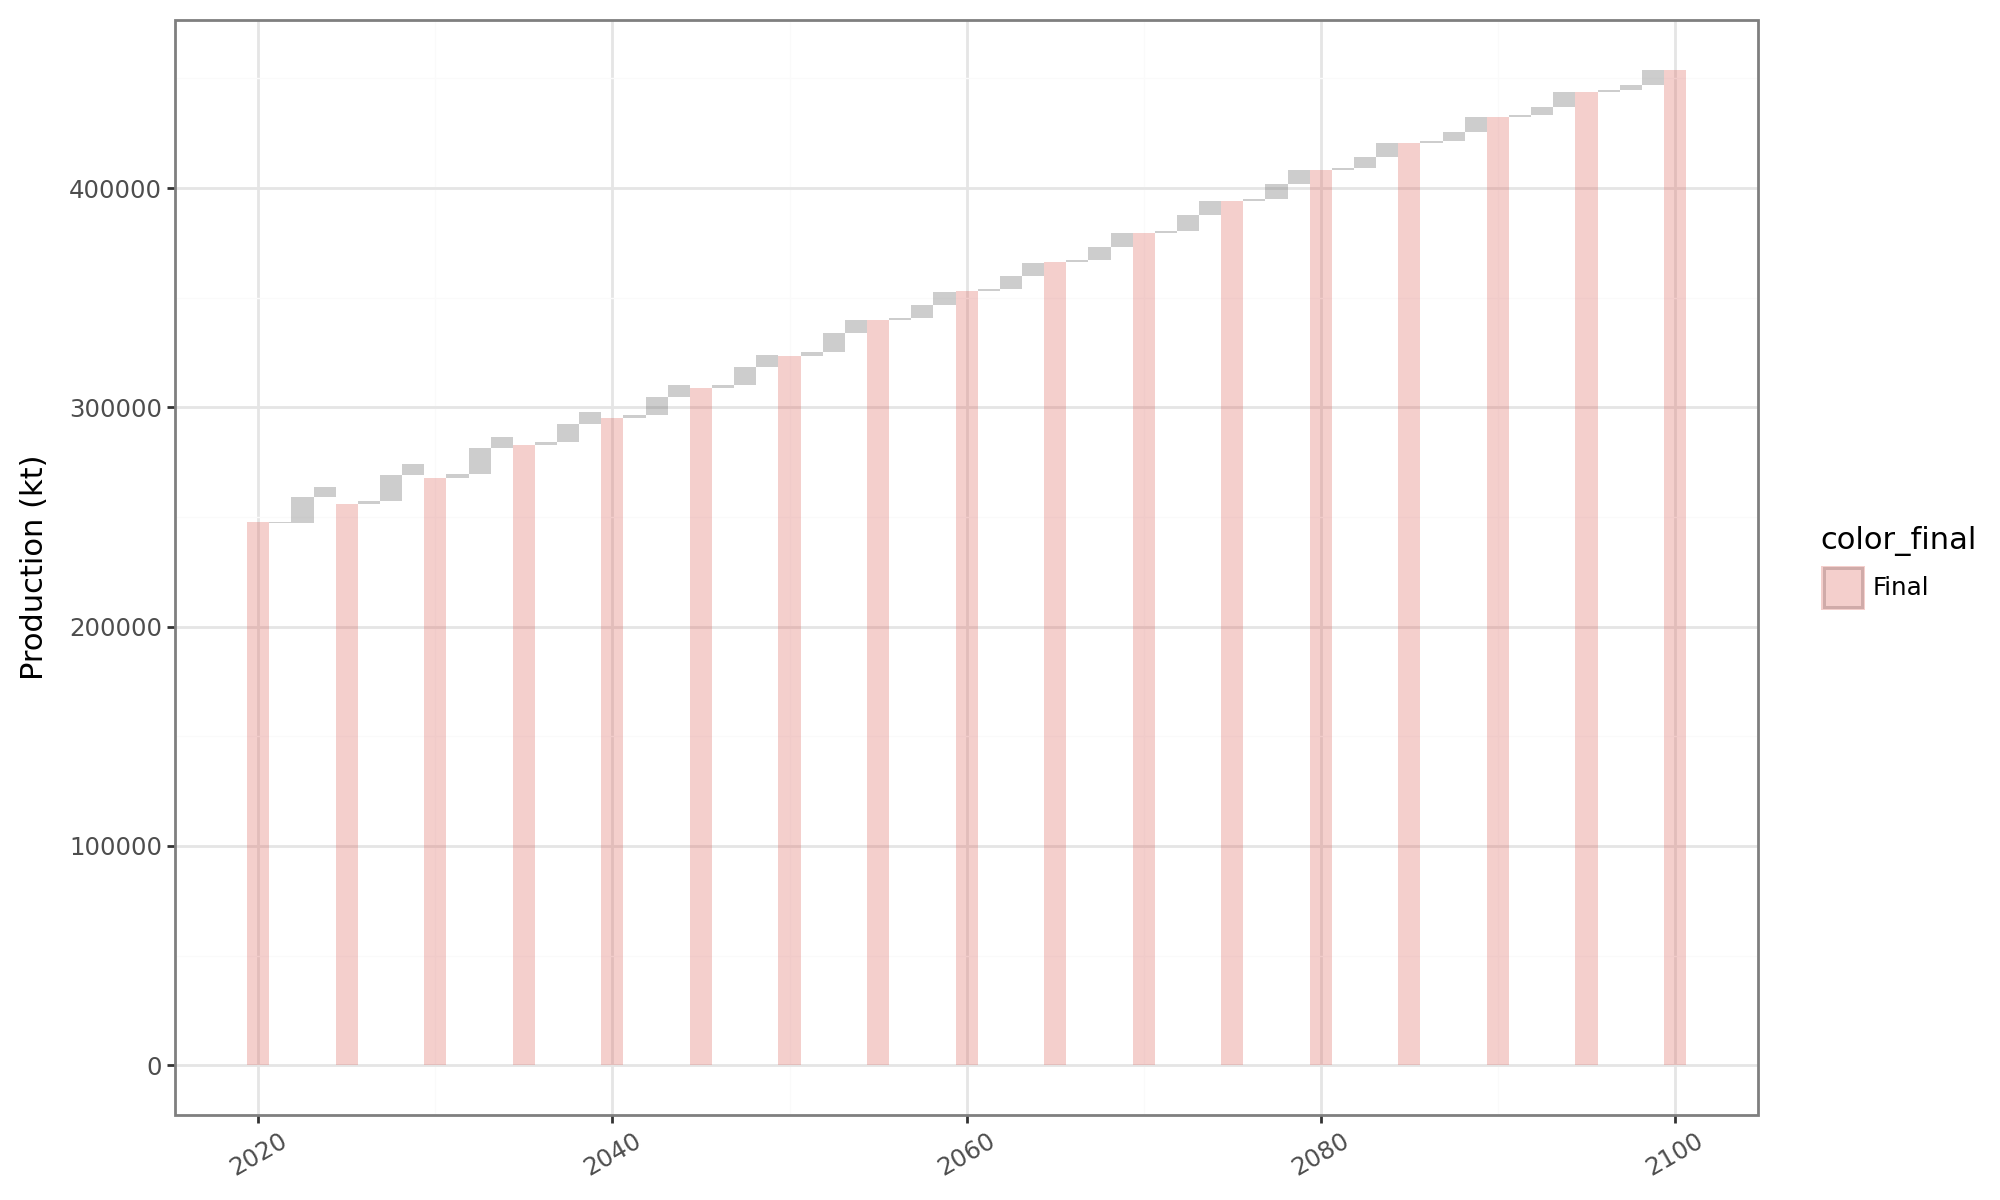

In [98]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (10, 6)
plotnine.options.dpi = 100

(ggplot() +
 # final production
 geom_rect(pred_actual_select, aes(xmin='actual_x_min',xmax='actual_x_max',
                  ymin='actual_y_min',ymax='actual_y_max',fill='color_final'),alpha=0.3) +
 # climate production gap
 geom_rect(prod_actual_with_climate_select, aes(xmin='climate_x_min',xmax='climate_x_max',
                        ymin='climate_y_min',ymax='climate_y_max'),alpha=0.3) +
 # tech gap
 geom_rect(prod_actual_with_climate_tech_select, aes(xmin='tech_x_min',xmax='tech_x_max',
                           ymin='tech_y_min',ymax='tech_y_max'),alpha=0.3) +
 # reclamation gap
 geom_rect(prod_actual_with_climate_tech_reclamation_select, aes(xmin='reclamation_x_min',xmax='reclamation_x_max',
                                ymin='reclamation_y_min',ymax='reclamation_y_max'),alpha=0.3) +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
#  coord_cartesian(ylim=(200000,380000)) +
 ylab('Production (kt)')
)

#### step_5): compute the urban expansion that reduces crop production
- coresponding to the blank column in the illustration fig
- urban_expansion_loss = lag_area * BAU_yield

In [101]:
# IMPORTANT! remember to sort values so that the order mathes the order after groupby
urban_encroach_gap = urban_encroach_img.copy()
urban_encroach_gap = urban_encroach_gap.sort_values(['SSP','crop','water','year']).reset_index(drop=True)

# append the lag_year record (e.g 2025 to 2020)
urban_encroach_gap['lag_area'] = urban_encroach_img.groupby(['SSP','crop','water'])\
                      .apply(lambda df,idx:df['cropland_encroached_by_urban'].shift(-1),1)\
                      .reset_index()['cropland_encroached_by_urban'].tolist()

# merge with harvested area
urban_reduce_gap = urban_encroach_gap.merge(Scenario_BAU_yield_img).dropna()

C:\Users\Jinzhu\AppData\Local\Temp\ipykernel_12120\2119905004.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [108]:
urban_encroach_gap.iloc[0]

SSP                                                                          SSP1
year                                                                         2020
crop                                                                        Maize
water                                                                   Irrigated
cropland_encroached_by_urban    ee.Image({\n  "functionInvocationValue": {\n  ...
lag_area                        ee.Image({\n  "functionInvocationValue": {\n  ...
Name: 0, dtype: object

In [109]:
def compute_urban_production(in_df,in_shp = NCP_provinces,name='EN_Name'):
  # hack to show process bar in multi-processing module
  print(' ',end='',flush=True)

  df_list = []
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df),leave=False):
    crop = row['crop']
    water = row['water']
    year = row['year']
    rcp = row['rcp']
    ssp = row['SSP']

    # get the farmland_area gap between now and then, (e.g., 2000 and 2005)
    gap_area = row['cropland_encroached_by_urban'].select('encroachment_led_farmland').subtract(row['lag_area'].select('encroachment_led_farmland'))
    gap_area_sd = row['cropland_encroached_by_urban'].select('encroachment_led_farmland_top').subtract(row['lag_area'].select('encroachment_led_farmland'))
    
    crop_yield = row['img_future'].unmask()
    crop_yield_sd = row['img_future_sd'].unmask()
    
    gap_production  = gap_area.multiply(crop_yield)
    gap_production_sd = cal_std(gap_area,crop_yield,gap_area_sd,crop_yield_sd)
    
    in_img = ee.Image([gap_production,gap_production_sd]).rename(['val','sd'])
    
    stats = in_img.reduceRegions(collection = in_shp, reducer = 'sum', scale = GAEZ_pix_scale).getInfo()
    stats_df = pd.DataFrame({i['properties'][name]:[i['properties']['val']] for i in stats['features']}).T.reset_index()
    stats_df['sd'] = [i['properties']['sd'] for i in stats['features']]


    # append infomation
    stats_df.columns=['Province','Gap Production','Gap Production sd']
    stats_df['crop'] = crop
    stats_df['water'] = water
    stats_df['year'] = year
    stats_df['rcp'] = rcp
    stats_df['ssp'] = ssp

    # store df                        
    df_list.append(stats_df)

  # concat dfs
  out_df = pd.concat(df_list,ignore_index=True)
  
  return out_df

In [111]:
# # get the total production for each ['crop','water','rcp','year','province']
# urban_production_df = parallelize_dataframe(urban_reduce_gap,compute_urban_production,60)
# urban_production_df.to_csv(f'./result_csv/urban_production_df.csv',index=False)

# # get the total production for each ['rcp','ssp','year']
# urban_production_sum_df = urban_production_df.groupby(['rcp','ssp','year']).sum(numeric_only=True).reset_index()
# urban_production_sum_df['rcp'] = urban_production_sum_df['rcp'].astype(int)
# urban_production_sum_df.to_csv(f'./result_csv/urban_production_sum_df.csv',index=False)

urban_production_df = pd.read_csv(f'./result_csv/urban_production_df.csv')
urban_production_sum_df = pd.read_csv(f'./result_csv/urban_production_sum_df.csv')

In [112]:
# merge tech_gap with climate and actual production
prod_actual_with_climate_tech_reclamation_urban = prod_actual_with_climate_tech_reclamation\
                      .merge(urban_production_sum_df,on=['rcp','ssp','year'])

# compute the crop production induced by urbanization
prod_actual_with_climate_tech_reclamation_urban['urban_x_min'] = prod_actual_with_climate_tech_reclamation_urban['year'] + 5/8*7
prod_actual_with_climate_tech_reclamation_urban['urban_x_max'] = prod_actual_with_climate_tech_reclamation_urban['year'] + 5/8*9
prod_actual_with_climate_tech_reclamation_urban['urban_y_min'] = prod_actual_with_climate_tech_reclamation_urban['reclamation_y_max'] 
prod_actual_with_climate_tech_reclamation_urban['urban_y_max'] = prod_actual_with_climate_tech_reclamation_urban['reclamation_y_max'] \
                                - prod_actual_with_climate_tech_reclamation_urban['Gap Production']

# rename the gap production to gap_reclamation
prod_actual_with_climate_tech_reclamation_urban = prod_actual_with_climate_tech_reclamation_urban \
                            >> rename(gap_urban='Gap Production')
prod_actual_with_climate_tech_reclamation_urban = prod_actual_with_climate_tech_reclamation_urban \
                            >> rename(gap_urban_sd='Gap Production sd')

# add color columns for plotting
prod_actual_with_climate_tech_reclamation_urban['color_climate'] = 'Climate'
prod_actual_with_climate_tech_reclamation_urban['color_tech'] = 'Technology'
prod_actual_with_climate_tech_reclamation_urban['color_reclamation'] = 'Reclamation'
prod_actual_with_climate_tech_reclamation_urban['color_urban'] = 'Urban'


# save to disk
prod_actual_with_climate_tech_reclamation_urban.to_csv('./result_csv/prod_actual_with_climate_tech_reclamation_urban.csv',index=False)

In [113]:
# filter for plot
prod_actual_with_climate_tech_reclamation_urban_select = prod_actual_with_climate_tech_reclamation_urban \
                              >> mask(X.rcp == 45, X.ssp=='SSP3')
prod_actual_with_climate_tech_reclamation_urban_select.head()

,rcp,ssp,year,Total Production sd,actual_x_min,actual_x_max,actual_y_min,actual_y_max,color_final,gap_climate,...,gap_urban,gap_urban_sd,urban_x_min,urban_x_max,urban_y_min,urban_y_max,color_climate,color_tech,color_reclamation,color_urban
110,45,SSP3,2020,15483.156719,2019.375,2020.625,0,247744.450835,Final,-375.785035,...,7788.270335,4305.805849,2024.375,2025.625,263589.256754,255800.986419,Climate,Technology,Reclamation,Urban
111,45,SSP3,2025,21983.694588,2024.375,2025.625,0,255709.214507,Final,1569.646943,...,6120.891045,1370.077359,2029.375,2030.625,274023.908391,267903.017346,Climate,Technology,Reclamation,Urban
112,45,SSP3,2030,39988.927925,2029.375,2030.625,0,267855.998684,Final,1559.564936,...,3945.213154,1438.196153,2034.375,2035.625,286526.764657,282581.551502,Climate,Technology,Reclamation,Urban
113,45,SSP3,2035,50004.321229,2034.375,2035.625,0,282661.872460,Final,1566.653762,...,2825.094000,2886.887175,2039.375,2040.625,297737.693707,294912.599707,Climate,Technology,Reclamation,Urban
114,45,SSP3,2040,63868.047913,2039.375,2040.625,0,294997.173345,Final,1582.367851,...,1854.275265,5621.056139,2044.375,2045.625,310334.531885,308480.256620,Climate,Technology,Reclamation,Urban


we can see some of the urban columns are not exactly match the bottom of the next climate columns. That may because the GEE ignores some of the pixels in the shp boundary. 

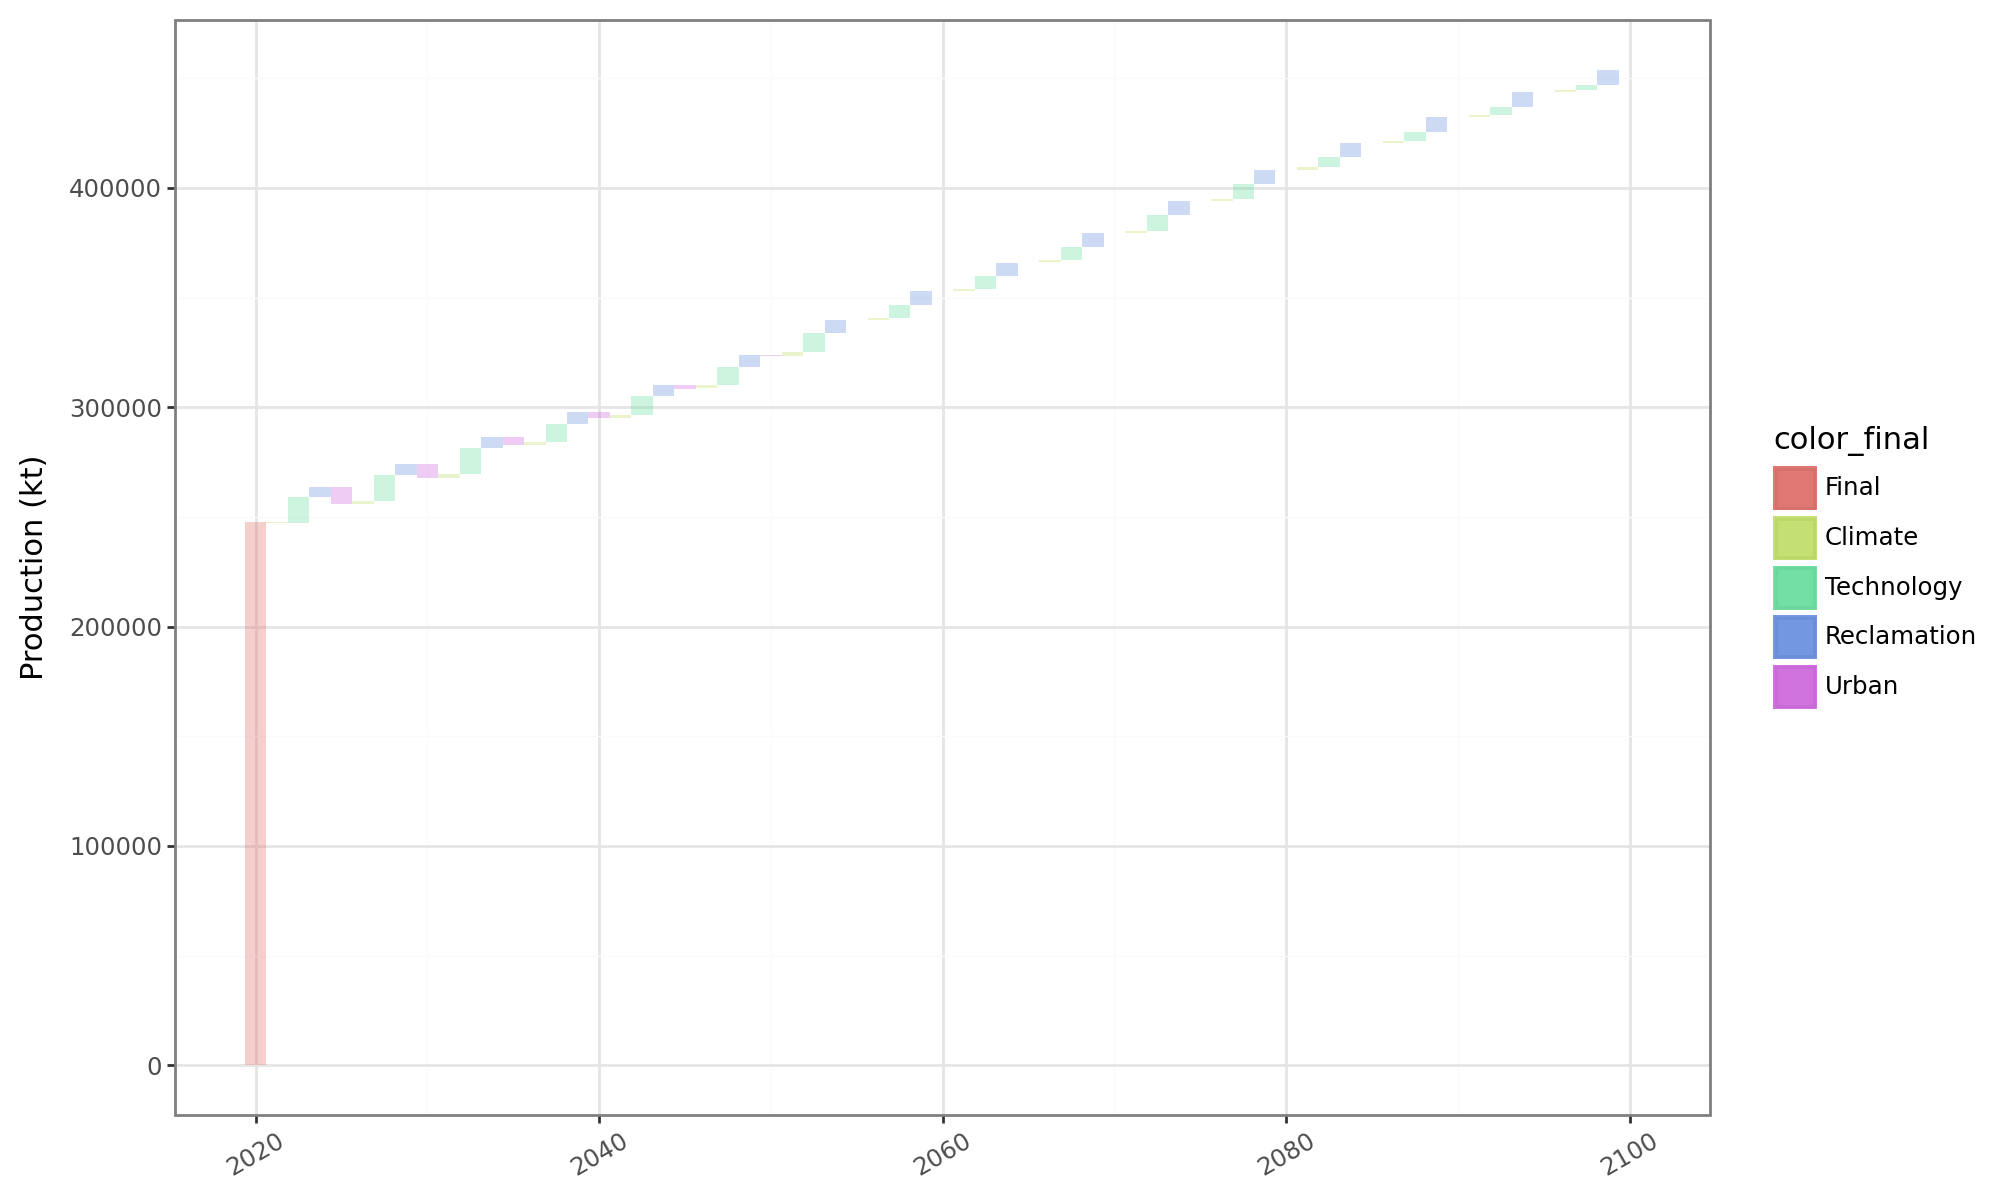

In [114]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (10, 6)
plotnine.options.dpi = 100

(ggplot() +
 # final production
 geom_rect(prod_actual_with_climate_tech_reclamation_urban_select >> mask((X.year == 2020)), 
     aes(xmin='actual_x_min',xmax='actual_x_max', ymin='actual_y_min',ymax='actual_y_max',fill='color_final'),alpha=0.3) +
 # climate production gap
 geom_rect(prod_actual_with_climate_tech_reclamation_urban_select, aes(xmin='climate_x_min',xmax='climate_x_max',
                        ymin='climate_y_min',ymax='climate_y_max',fill='color_climate'),alpha=0.3) +
 # tech gap
 geom_rect(prod_actual_with_climate_tech_reclamation_urban_select, aes(xmin='tech_x_min',xmax='tech_x_max',
                           ymin='tech_y_min',ymax='tech_y_max',fill='color_tech'),alpha=0.3) +
 # reclamation gap
 geom_rect(prod_actual_with_climate_tech_reclamation_urban_select, aes(xmin='reclamation_x_min',xmax='reclamation_x_max',
                          ymin='reclamation_y_min',ymax='reclamation_y_max',fill='color_reclamation'),alpha=0.3) +
 # urban gap
 geom_rect(prod_actual_with_climate_tech_reclamation_urban_select, aes(xmin='urban_x_min',xmax='urban_x_max',
                                ymin='urban_y_min',ymax='urban_y_max',fill='color_urban'),alpha=0.3) +
#  coord_cartesian(ylim=(200000,380000)) +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Production (kt)')
)

### Extra part: let's compute the stats for each city of NCP

In [ ]:
from functools import partial

In [ ]:
# pred_actual_production_df_cities = parallelize_dataframe(pred_actual_production,partial(compute_actual_crop_production,in_shp=NCP_cites,name='CityNameC'),30)
# pred_actual_production_df_cities.to_csv(f'./result_csv/pred_actual_production_df_cities.csv',index=False)

# climate_production_df_cites = parallelize_dataframe(climate_production_gap,partial(compute_climate_production,in_shp=NCP_cites,name='CityNameC'),30)
# climate_production_df_cites.to_csv(f'./result_csv/climate_production_df_cites.csv',index=False)

# tech_production_df_cites = parallelize_dataframe(tech_production_gap,partial(compute_tech_production,in_shp=NCP_cites,name='CityNameC'),30)
# tech_production_df_cites.to_csv(f'./result_csv/tech_production_df_cites.csv',index=False)

# reclamation_production_df_cites = parallelize_dataframe(reclamation_production_gap,partial(compute_reclamation_production,in_shp=NCP_cites,name='CityNameC'),30)
# reclamation_production_df_cites.to_csv(f'./result_csv/reclamation_production_df_cites.csv',index=False)

# urban_production_df_cites = parallelize_dataframe(urban_reduce_gap,partial(compute_urban_production,in_shp=NCP_cites,name='CityNameC'),30)
# urban_production_df_cites.to_csv(f'./result_csv/urban_production_df_cites.csv',index=False)